# 我们研究Au核核形变效应对d+Au碰撞的影响

### Au核具有轻微的形变，大多数情况下，我们认为其是球形核，但是研究表明其存在四极形变$\beta_2$

##  $$\rho(r, \theta) = \frac{\rho_0}{1 + e^{[r - R(1 + \beta_2 Y_{20}(\theta)]/a}}$$

### 球形核：$a=0.535, R=6.38,  \beta_2=0$  
### 形变核：$a=0.53, R=6.40, \beta_2=-0.13$

# 一、 对Au核采样

In [55]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import mplhep as hep
hep.style.use('ATLAS')
import h5py


In [56]:
import numpy as np
from tqdm import tqdm

class NuclearSampler:
    def __init__(self, rho0=0.16):
        """初始化参数"""
        self.rho0 = rho0  # 核物质中心密度 (fm^-3)
    
    def Y20(self, theta):
        return np.sqrt(5 / (16 * np.pi)) * (3 * np.cos(theta)**2 - 1)

    def Y40(self, theta):
        return (3 / 16) * np.sqrt(1 / np.pi) * (35 * np.cos(theta)**4 - 30 * np.cos(theta)**2 + 3)

    def density_spherical(self, r, a, R0):
        """球形核(beta_2 = 0)的密度分布（包含r^2项）"""
        rho = self.rho0 / (1 + np.exp((r - R0)/a))
        return rho * r**2
    
    def density_deformed(self, r, theta, a, R0, beta2):
        """形变核(beta_2 != 0)的密度分布（包含r^2 sin(theta)项）"""
        Y20_val = self.Y20(theta)
        R_theta = R0 * (1 + beta2 * Y20_val)
        rho = self.rho0 / (1 + np.exp((r - R_theta)/a))
        return rho * r**2 * np.sin(theta)

    def density_deformed_beta4(self, r, theta, a, R0, beta2, beta4):
        """支持 beta2 和 beta4 的形变核密度分布"""
        Y20_val = self.Y20(theta)
        Y40_val = self.Y40(theta)
        R_theta = R0 * (1 + beta2 * Y20_val + beta4 * Y40_val)
        rho = self.rho0 / (1 + np.exp((r - R_theta)/a))
        return rho * r**2 * np.sin(theta)
    
    def sample_theta(self):
        """采样theta（符合p(theta) = sin(theta)/2分布）"""
        u = np.random.rand()
        return np.arccos(1 - 2 * u)  # 逆变换采样

    def sample_spherical(self, a, R0, n_samples=1000):
        """采样球形核(r, theta)"""
        r_max = 15
        pdf_max = 5
        
        samples = []
        with tqdm(total=n_samples, desc="Sampling spherical nucleus") as pbar:
            while len(samples) < n_samples:
                r = np.random.uniform(0, r_max)
                if np.random.uniform(0, pdf_max) < self.density_spherical(r, a, R0):
                    theta = self.sample_theta()
                    samples.append([r, theta])
                    pbar.update(1)
        return np.array(samples)
    
    def sample_deformed_beta2(self, a, R0, beta2, n_samples=1000):
        """采样形变核(r, theta)"""
        r_max = 15
        pdf_max = 5

        samples = []
        with tqdm(total=n_samples, desc="Sampling deformed nucleus") as pbar:
            while len(samples) < n_samples:
                r = np.random.uniform(0, r_max)
                theta = np.random.uniform(0, np.pi)
                if np.random.uniform(0, pdf_max) < self.density_deformed(r, theta, a, R0, beta2):
                    samples.append([r, theta])
                    pbar.update(1)
        return np.array(samples)
    
    def sample_deformed_beta4(self, a, R0, beta2, beta4, n_samples=1000):
        """采样包含 beta2 和 beta4 的形变核(r, theta)"""
        r_max = 15
        pdf_max = 5

        samples = []
        with tqdm(total=n_samples, desc="Sampling beta2+beta4 deformed nucleus") as pbar:
            while len(samples) < n_samples:
                r = np.random.uniform(0, r_max)
                theta = np.random.uniform(0, np.pi)
                if np.random.uniform(0, pdf_max) < self.density_deformed_beta4(r, theta, a, R0, beta2, beta4):
                    samples.append([r, theta])
                    pbar.update(1)
        return np.array(samples)


### 采样和保存数据

In [57]:
# # 创建采样器
# sampler = NuclearSampler()

# # Au核参数
# params_spherical = {'a': 0.535, 'R0': 6.38}
# params_deformed_beta2 = {'a': 0.535, 'R0': 6.38, 'beta2': -0.131}
# params_deformed_beta4 = {'a': 0.535, 'R0': 6.38, 'beta2': -0.131, 'beta4': -0.031}

# # 开始采样
# num_nuclei=250000
# num_nucleons=197
# samples_sph = sampler.sample_spherical(n_samples=num_nucleons*num_nuclei, **params_spherical)
# samples_def_beta2 = sampler.sample_deformed_beta2(n_samples=num_nucleons*num_nuclei, **params_deformed_beta2)
# samples_def_beta4 = sampler.sample_deformed_beta4(n_samples=num_nucleons*num_nuclei, **params_deformed_beta4)

# print(f"Spherical samples shape: {samples_sph.shape}")
# print(f"Deformed (beta2) samples shape: {samples_def.shape}")
# print(f"Deformed (beta2+beta4) samples shape: {samples_def_beta4.shape}") # 应为 (N,2)


In [58]:
# # 生成均匀分布的角度phi
# phi = np.random.uniform(0, 2 * np.pi, size=num_nuclei*num_nucleons)

# # 将phi分布添加到samples_sph和samples_def中
# samples_sph_3d = np.column_stack((samples_sph, phi))
# samples_def_beta2_3d = np.column_stack((samples_def, phi))
# samples_def_beta4_3d = np.column_stack((samples_def_beta4, phi))


# # 此时samples_sph、samples_def和samples_def_beta4_3d的形状都变成了(197*10000000, 3)
# print(samples_sph_3d.shape)
# print(samples_def_beta2_3d.shape)
# print(samples_def_beta4_3d.shape)

In [59]:
# np.savetxt("/home/mengzhu/mywork/d_Au_work/data/Au_r_theta_phi_spherical_197_1000000.txt", samples_sph_3d)
# np.savetxt("/home/mengzhu/mywork/d_Au_work/data/Au_r_theta_phi_deformed_beta2_197_1000000.txt", samples_def_3d)
# np.savetxt("/home/mengzhu/mywork/d_Au_work/data/Au_r_theta_phi_deformed_beta4_197_1000000.txt", samples_def_beta4_3d)

In [60]:
# # 1. 定义文件列表
# file_paths = [
#     "/home/mengzhu/mywork/d_Au_work/data/Au_r_theta_phi_deformed_beta2_197_250000_p1.txt",
#     "/home/mengzhu/mywork/d_Au_work/data/Au_r_theta_phi_deformed_beta2_197_250000_p2.txt",
#     "/home/mengzhu/mywork/d_Au_work/data/Au_r_theta_phi_deformed_beta2_197_250000_p3.txt",
#     "/home/mengzhu/mywork/d_Au_work/data/Au_r_theta_phi_deformed_beta2_197_250000_p4.txt"
# ]

# # 2. 直接加载并合并
# combined_data = np.concatenate([np.loadtxt(f) for f in file_paths], axis=0)

# # 3. 验证结果
# print("合并后形状:", combined_data.shape)  # 应输出 (197000000, 3)

In [61]:
# np.savetxt("/home/mengzhu/mywork/d_Au_work/data/Au_r_theta_phi_deformed_beta2_197_1000000.txt", combined_data)

### 读取已采样两种Au核的结果

In [62]:
Au_sph=np.loadtxt("/home/mengzhu/mywork/d_Au_work/data/Au_r_theta_phi_spherical_197_1000000.txt")
Au_def_beta2=np.loadtxt("/home/mengzhu/mywork/d_Au_work/data/Au_r_theta_phi_deformed_beta2_197_1000000.txt")
Au_def_beta4=np.loadtxt("/home/mengzhu/mywork/d_Au_work/data/Au_r_theta_phi_deformed_beta4_197_1000000.txt")

In [63]:
sph_r = Au_sph[:,0]
sph_theta = Au_sph[:,1]
sph_phi = Au_sph[:,2]

def_beta2_r = Au_def_beta2[:,0]
def_beta2_theta = Au_def_beta2[:,1]
def_beta2_phi = Au_def_beta2[:,2]

def_beta4_r = Au_def_beta4[:,0]
def_beta4_theta = Au_def_beta4[:,1]
def_beta4_phi = Au_def_beta4[:,2]

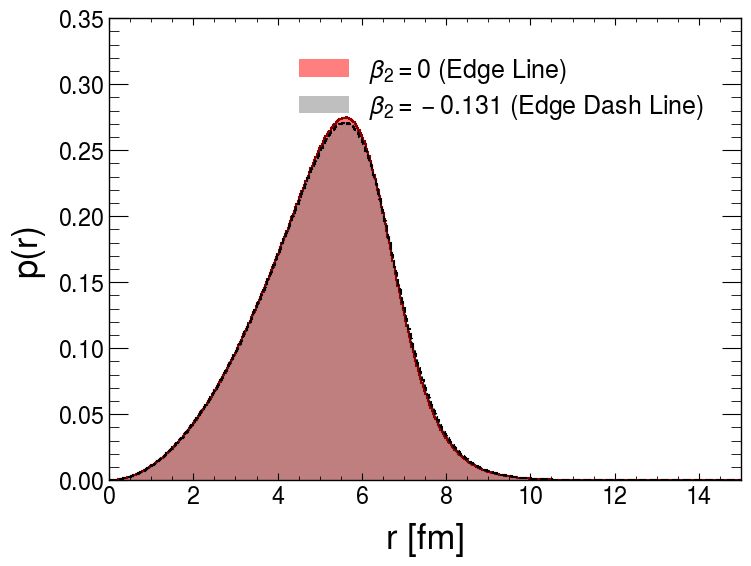

In [65]:
# 绘制两种beta2下r的对比情况
fig = plt.figure(figsize=(8, 6))

# 1. 绘制半透明柱状图（填充色）
hist_DWF = plt.hist(sph_r, bins=500, density=True, color='red', alpha=0.5, 
                    edgecolor='none', label=r'$\beta_2=0$ (Edge Line)')
hist_HWF = plt.hist(def_beta2_r, bins=500, density=True, color='grey', alpha=0.5, 
                    edgecolor='none', label=r'$\beta_2=-0.131$ (Edge Dash Line)')

# 2. 绘制顶部线（用step样式，但不添加到图例）
plt.hist(sph_r, bins=500, density=True, color='darkred', 
         histtype='step', linestyle='-', linewidth=1.5, label='_nolegend_')
plt.hist(def_beta2_r, bins=500, density=True, color='black', 
         histtype='step', linestyle='--', linewidth=1.5, label='_nolegend_')

plt.xlim(0,15)
plt.ylim(0,0.35)

plt.xlabel('r [fm]', ha='center', fontsize=25)
plt.ylabel('p(r)', ha='center', fontsize=25)
plt.legend(fontsize=18)
# plt.savefig("/home/mengzhu/mywork/d_Au_work/fig/r_dis_between_sph_and_def2_lines.pdf", bbox_inches="tight")
plt.show()


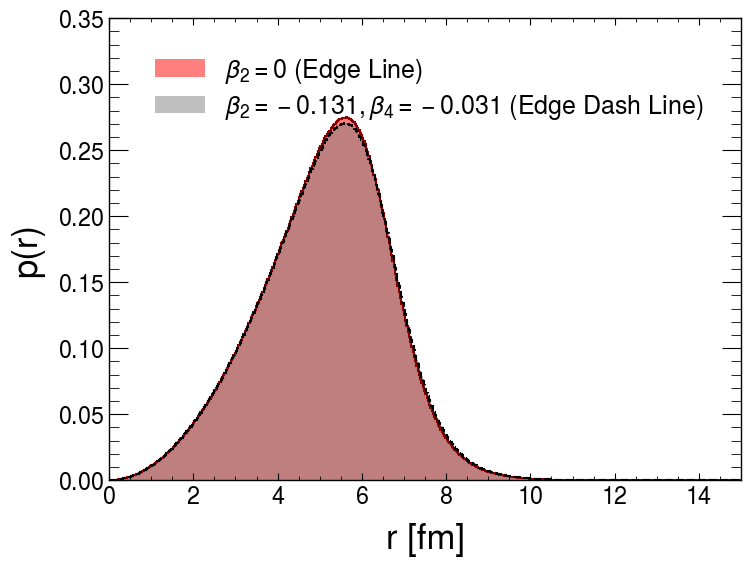

In [66]:
# 绘制两种beta2下r的对比情况
fig = plt.figure(figsize=(8, 6))

# 1. 绘制半透明柱状图（填充色）
hist_DWF = plt.hist(sph_r, bins=500, density=True, color='red', alpha=0.5, 
                    edgecolor='none', label=r'$\beta_2=0$ (Edge Line)')
hist_HWF = plt.hist(def_beta4_r, bins=500, density=True, color='grey', alpha=0.5, 
                    edgecolor='none', label=r'$\beta_2=-0.131,\beta_4=-0.031$ (Edge Dash Line)')

# 2. 绘制顶部线（用step样式，但不添加到图例）
plt.hist(sph_r, bins=500, density=True, color='darkred', 
         histtype='step', linestyle='-', linewidth=1.5, label='_nolegend_')
plt.hist(def_beta4_r, bins=500, density=True, color='black', 
         histtype='step', linestyle='--', linewidth=1.5, label='_nolegend_')

plt.xlim(0,15)
plt.ylim(0,0.35)

plt.xlabel('r [fm]', ha='center', fontsize=25)
plt.ylabel('p(r)', ha='center', fontsize=25)
plt.legend(fontsize=18)
# plt.savefig("/home/mengzhu/mywork/d_Au_work/fig/r_dis_between_sph_and_def4_lines.pdf", bbox_inches="tight")
plt.show()


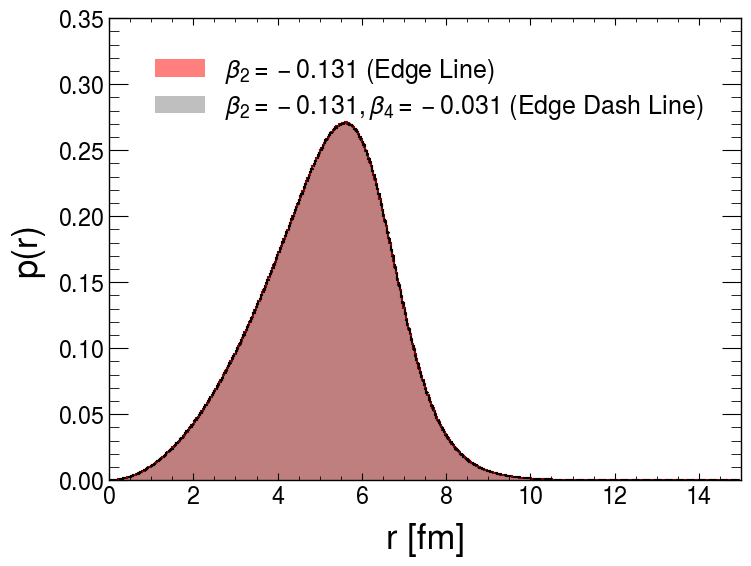

In [67]:
# 绘制两种beta2下r的对比情况
fig = plt.figure(figsize=(8, 6))

# 1. 绘制半透明柱状图（填充色）
hist_DWF = plt.hist(def_beta2_r, bins=500, density=True, color='red', alpha=0.5, 
                    edgecolor='none', label=r'$\beta_2=-0.131$ (Edge Line)')
hist_HWF = plt.hist(def_beta4_r, bins=500, density=True, color='grey', alpha=0.5, 
                    edgecolor='none', label=r'$\beta_2=-0.131,\beta_4=-0.031$ (Edge Dash Line)')

# 2. 绘制顶部线（用step样式，但不添加到图例）
plt.hist(def_beta2_r, bins=500, density=True, color='darkred', 
         histtype='step', linestyle='-', linewidth=1.5, label='_nolegend_')
plt.hist(def_beta4_r, bins=500, density=True, color='black', 
         histtype='step', linestyle='--', linewidth=1.5, label='_nolegend_')

plt.xlim(0,15)
plt.ylim(0,0.35)

plt.xlabel('r [fm]', ha='center', fontsize=25)
plt.ylabel('p(r)', ha='center', fontsize=25)
plt.legend(fontsize=18)
# plt.savefig("/home/mengzhu/mywork/d_Au_work/fig/r_dis_between_def2_and_def4_lines.pdf", bbox_inches="tight")
plt.show()


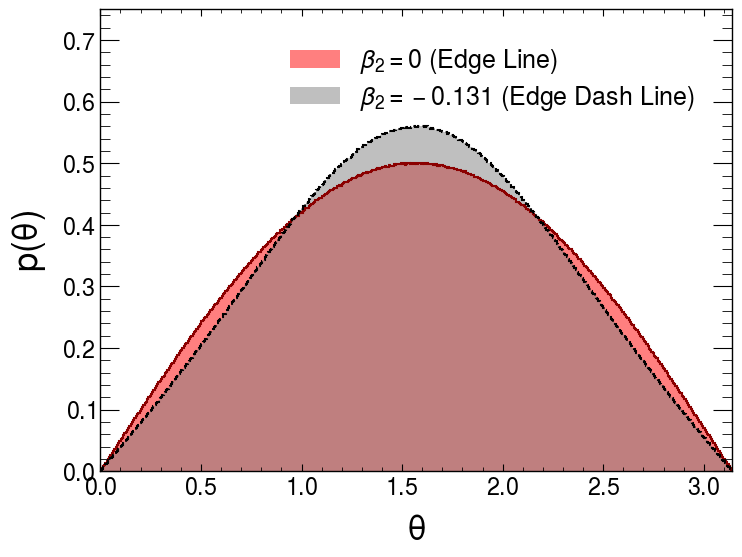

In [68]:
fig = plt.figure(figsize=(8, 6))  # 创建一个8x6英寸的图形对象

# 1. 绘制半透明柱状图（填充色）
_ = plt.hist(sph_theta, bins=500, density=True, color='red', alpha=0.5, 
             edgecolor='none', label=r'$\beta_2=0$ (Edge Line)')
_ = plt.hist(def_beta2_theta, bins=500, density=True, color='grey', alpha=0.5, 
             edgecolor='none', label=r'$\beta_2=-0.131$ (Edge Dash Line)')

# 2. 绘制顶部线（用step样式，但不添加到图例）
_ = plt.hist(sph_theta, bins=500, density=True, color='darkred', 
             histtype='step', linestyle='-', linewidth=1.5, label='_nolegend_')
_ = plt.hist(def_beta2_theta, bins=500, density=True, color='black', 
             histtype='step', linestyle='--', linewidth=1.5, label='_nolegend_')

plt.xlim(0, np.pi)
plt.ylim(0, 0.75)

plt.xlabel(r'$\rm \theta$', ha='center', fontsize=25)
plt.ylabel(r'p($\rm \theta$)', ha='center', fontsize=25)
plt.legend(fontsize=18)

# plt.savefig("/home/mengzhu/mywork/d_Au_work/fig/theta_dis_between_sph_and_def2_lines.pdf", bbox_inches="tight")
plt.show()

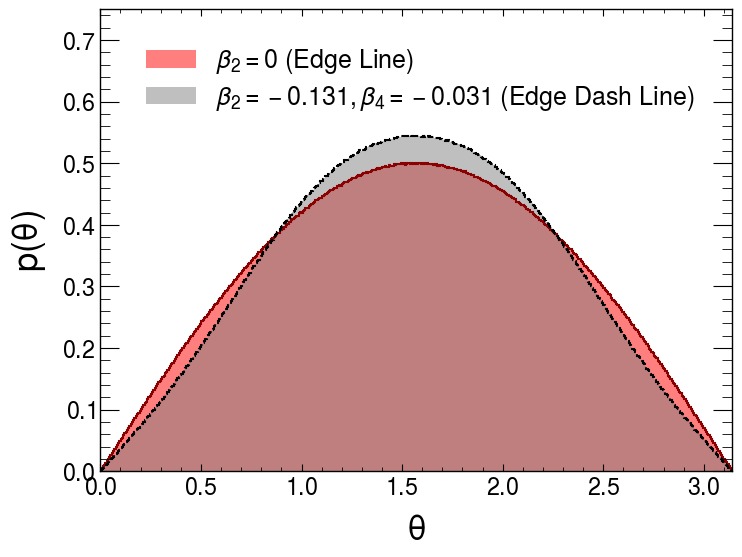

In [69]:
fig = plt.figure(figsize=(8, 6))  # 创建一个8x6英寸的图形对象

# 1. 绘制半透明柱状图（填充色）
_ = plt.hist(sph_theta, bins=500, density=True, color='red', alpha=0.5, 
             edgecolor='none', label=r'$\beta_2=0$ (Edge Line)')
_ = plt.hist(def_beta4_theta, bins=500, density=True, color='grey', alpha=0.5, 
             edgecolor='none', label=r'$\beta_2=-0.131,\beta_4=-0.031$ (Edge Dash Line)')

# 2. 绘制顶部线（用step样式，但不添加到图例）
_ = plt.hist(sph_theta, bins=500, density=True, color='darkred', 
             histtype='step', linestyle='-', linewidth=1.5, label='_nolegend_')
_ = plt.hist(def_beta4_theta, bins=500, density=True, color='black', 
             histtype='step', linestyle='--', linewidth=1.5, label='_nolegend_')

plt.xlim(0, np.pi)
plt.ylim(0, 0.75)

plt.xlabel(r'$\rm \theta$', ha='center', fontsize=25)
plt.ylabel(r'p($\rm \theta$)', ha='center', fontsize=25)
plt.legend(fontsize=18)

# plt.savefig("/home/mengzhu/mywork/d_Au_work/fig/theta_dis_between_sph_and_def4_lines.pdf", bbox_inches="tight")
plt.show()

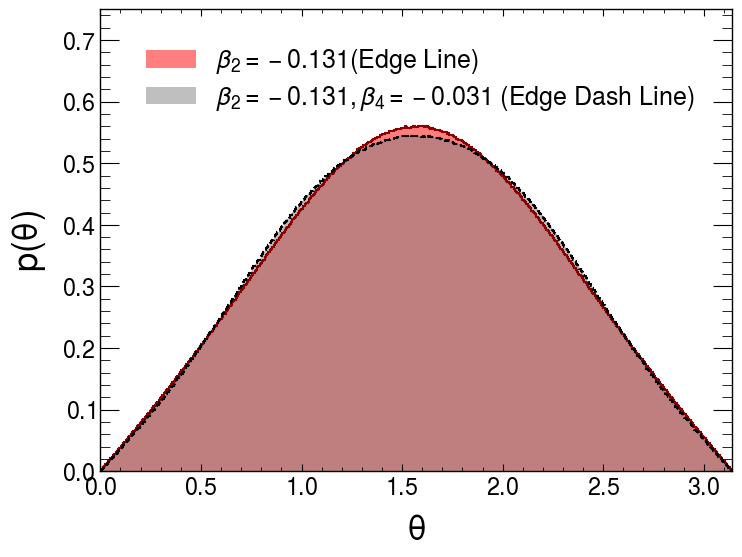

In [70]:
fig = plt.figure(figsize=(8, 6))  # 创建一个8x6英寸的图形对象

# 1. 绘制半透明柱状图（填充色）
_ = plt.hist(def_beta2_theta, bins=500, density=True, color='red', alpha=0.5, 
             edgecolor='none', label=r'$\beta_2=-0.131$(Edge Line)')
_ = plt.hist(def_beta4_theta, bins=500, density=True, color='grey', alpha=0.5, 
             edgecolor='none', label=r'$\beta_2=-0.131,\beta_4=-0.031$ (Edge Dash Line)')

# 2. 绘制顶部线（用step样式，但不添加到图例）
_ = plt.hist(def_beta2_theta, bins=500, density=True, color='darkred', 
             histtype='step', linestyle='-', linewidth=1.5, label='_nolegend_')
_ = plt.hist(def_beta4_theta, bins=500, density=True, color='black', 
             histtype='step', linestyle='--', linewidth=1.5, label='_nolegend_')

plt.xlim(0, np.pi)
plt.ylim(0, 0.75)

plt.xlabel(r'$\rm \theta$', ha='center', fontsize=25)
plt.ylabel(r'p($\rm \theta$)', ha='center', fontsize=25)
plt.legend(fontsize=18)

# plt.savefig("/home/mengzhu/mywork/d_Au_work/fig/theta_dis_between_def2_and_def4_lines.pdf", bbox_inches="tight")
plt.show()

### 实现球坐标（$r,\theta, \phi$）到直角坐标（x, y, z）的转换，并保存成 HDF5 格式文件，用于TRENTo运行

In [9]:
def spherical_to_cartesian(coords):
    """
    将球坐标 (r, theta, phi) 转换为直角坐标 (x, y, z)
    coords: shape (N, 3)，每行为 (r, theta, phi)
    返回 shape (N, 3) 的数组
    """
    r, theta, phi = coords[:, 0], coords[:, 1], coords[:, 2]
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return np.stack((x, y, z), axis=1)


In [10]:
def process_and_save_coords(coords, filename, num_nuclei, num_nucleons):
    """
    将球坐标转换为直角坐标，并保存为 HDF5 文件
    - coords: shape (num_nuclei * num_nucleons, 3)，球坐标数组
    - filename: 输出文件名（包括路径）
    - num_nuclei: 核的个数
    - num_nucleons: 每个核的核子数
    """
    # 坐标转换
    cartesian_flat = spherical_to_cartesian(coords)

    # reshape 成 (num_nuclei, num_nucleons, 3)
    cartesian_data = cartesian_flat.reshape(num_nuclei, num_nucleons, 3)

    # 保存为 HDF5 文件
    with h5py.File(filename, 'w') as f:
        f.create_dataset("positions", data=cartesian_data)
        f.attrs["description"] = "Au nuclei Cartesian coordinates"

    print(f"数据处理完成！文件已保存为 {filename}")


In [11]:
# 处理 spherical 形状的Au核
# coords.shape 应该为 (1000000 * 197, 3)
process_and_save_coords(coords=Au_def_beta4,
                        filename="/home/mengzhu/mywork/d_Au_work/data/Au_xyz_def_beta4_1000000.h5",
                        num_nuclei=1000000,
                        num_nucleons=197)


数据处理完成！文件已保存为 /home/mengzhu/mywork/d_Au_work/data/Au_xyz_def_beta4_1000000.h5


# 二、使用采样的结果，运行TRENTo，查看碰撞初态的几何量信息

In [2]:
#导入DWF采样后trento中的氘核与金核碰撞的结果，此结果包含ncoll项

trento2d_HWF_sph = np.loadtxt("/home/mengzhu/mywork/d_Au_work/data/trento2d_HWF_d_sph_Au_ncoll_10000000.dat")
trento2d_HWF_def2 = np.loadtxt("/home/mengzhu/mywork/d_Au_work/data/trento2d_HWF_d_def_beta2_Au_ncoll_10000000.dat")
trento2d_HWF_def4 = np.loadtxt("/home/mengzhu/mywork/d_Au_work/data/trento2d_HWF_d_def_beta4_Au_ncoll_10000000.dat")



In [3]:
trento2d_DWF_sph = np.loadtxt("/home/mengzhu/mywork/d_Au_work/data/trento2d_DWF_d_sph_Au_ncoll_10000000.dat")
trento2d_DWF_def2 = np.loadtxt("/home/mengzhu/mywork/d_Au_work/data/trento2d_DWF_d_def_beta2_Au_ncoll_10000000.dat")
trento2d_DWF_def4 = np.loadtxt("/home/mengzhu/mywork/d_Au_work/data/trento2d_DWF_d_def_beta4_Au_ncoll_10000000.dat")



In [15]:
# TRENTo2d_InitialDataVisualizer_without_errorbar 

import matplotlib.ticker as ticker
class TRENTo2d_InitialDataVisualizer_without_errorbar:
    def __init__(self, data_DWF, data_HWF):
        """
        初始化类，传入数据
        data_DWF: 第一组数据
        data_HWF: 第二组数据
        """
        self.data_DWF = data_DWF
        self.data_HWF = data_HWF
        self.column_labels = {
            1: r"$\rm b$",
            2: r"$\rm N_{part}$",
            3: r"$\rm N_{coll}$",
            4: r"$\rm Total \quad Entropy$",
            5: r"$\rm <\epsilon_2>$",
            6: r"$\rm <\epsilon_3>$",
            7: r"$\rm <\epsilon_4>$",
            8: r"$\rm <\epsilon_5>$"
        }
        self.column_labels_delta = {
            1: r"$\rm b$",
            2: r"$\rm N_{part}$",
            3: r"$\rm N_{coll}$",
            4: r"$\rm Total \quad Entropy$",
            5: r"$\rm \sqrt{<\epsilon_2^2>-<\epsilon_2>^2}$",
            6: r"$\rm \sqrt{<\epsilon_3^2>-<\epsilon_3>^2}$",
            7: r"$\rm \sqrt{<\epsilon_4^2>-<\epsilon_4>^2}$",
            8: r"$\rm \sqrt{<\epsilon_5^2>-<\epsilon_5>^2}$"
        }
        self.column_labels_delta2 = {
            1: r"$\rm b$",
            2: r"$\rm N_{part}$",
            3: r"$\rm N_{coll}$",
            4: r"$\rm Total \quad Entropy$",
            5: r"$\rm <\epsilon_2^2>-<\epsilon_2>^2$",
            6: r"$\rm <\epsilon_3^2>-<\epsilon_3>^2$",
            7: r"$\rm <\epsilon_4^2>-<\epsilon_4>^2$",
            8: r"$\rm <\epsilon_5^2>-<\epsilon_5>^2$"
        }
        self.column_labels_sqr = {
            1: r"$\rm b$",
            2: r"$\rm N_{part}$",
            3: r"$\rm N_{coll}$",
            4: r"$\rm Total \quad Entropy$",
            5: r"$\rm <\epsilon_2^2>$",
            6: r"$\rm <\epsilon_3^2>$",
            7: r"$\rm <\epsilon_4^2>$",
            8: r"$\rm <\epsilon_5^2>$"
        }
        self.column_labels_sqr_sqrt = {
            1: r"$\rm b$",
            2: r"$\rm N_{part}$",
            3: r"$\rm N_{coll}$",
            4: r"$\rm Total \quad Entropy$",
            5: r"$\rm \sqrt{<\epsilon_2^2>}$",
            6: r"$\rm \sqrt{<\epsilon_3^2>}$",
            7: r"$\rm \sqrt{<\epsilon_4^2>}$",
            8: r"$\rm \sqrt{<\epsilon_5^2>}$"
        }

    def calc_column_relationship(self, data, col_x, col_y, bins=100):
        """
        计算两列数据之间的关系，返回区间中心，均值，均方差及误差
        """
        x_data = data[:, col_x]
        y_data = data[:, col_y]

        min_x = np.min(x_data)
        max_x = np.max(x_data)
        step = (max_x - min_x) / bins

        bin_centers = []
        y_means = []
        sqr_y_means = []
        y_errors = []
        sqr_y_errors = []
        
        for i in range(bins):
            lower_bound = min_x + i * step
            upper_bound = min_x + (i + 1) * step
            indices = (x_data >= lower_bound) & (x_data < upper_bound)

            if np.sum(indices) > 0:
                avg_y = np.mean(y_data[indices])
                avg_sqr_y = np.mean(y_data[indices]**2)
                
                std_y = np.std(y_data[indices])
                std_sqr_y = np.std(y_data[indices]**2)
                
                error_y = std_y / np.sqrt(np.sum(indices))
                error_sqr_y = std_sqr_y / np.sqrt(np.sum(indices))
                
                bin_centers.append((lower_bound + upper_bound) / 2)
                y_means.append(avg_y)
                sqr_y_means.append(avg_sqr_y)
                y_errors.append(error_y)
                sqr_y_errors.append(error_sqr_y)
                
        bin_centers = np.array(bin_centers)
        y_means = np.array(y_means)
        sqr_y_means = np.array(sqr_y_means)
        y_errors = np.array(y_errors)
        sqr_y_errors = np.array(sqr_y_errors)
        
        return bin_centers, y_means, sqr_y_means, y_errors, sqr_y_errors

    def plot_column_relationship(self, col_x, col_y, bins=100,loc='best'):
        """
        绘制单张图，比较两列数据之间的关系
        """
        xlabel = self.column_labels.get(col_x, f"Column {col_x}")
        ylabel = self.column_labels.get(col_y, f"Column {col_y}")

        bin_centers_DWF, y_means_DWF, y_means_sqr_DWF, yerr_DWF, yerr_sqr_DWF = self.calc_column_relationship(
            data=self.data_DWF, col_x=col_x, col_y=col_y, bins=bins)
        bin_centers_HWF, y_means_HWF, y_means_sqr_HWF, yerr_HWF, yerr_sqr_HWF = self.calc_column_relationship(
            data=self.data_HWF, col_x=col_x, col_y=col_y, bins=bins)

        plt.plot(bin_centers_DWF, y_means_DWF, linestyle='-', color='red', label="DWF")
        plt.plot(bin_centers_HWF, y_means_HWF, linestyle='--', color='grey', label="HWF")
        
        plt.xlabel(xlabel, ha='center', fontsize=25)
        plt.ylabel(ylabel, ha='center', fontsize=25)
        plt.legend(loc=loc,fontsize=20)
    
    def plot_column_relationship_delta(self, col_x, col_y, bins=100,loc='best'):
        """
        绘制单张图，比较两列数据之间的关系
        """
        xlabel = self.column_labels_delta.get(col_x, f"Column {col_x}")
        ylabel = self.column_labels_delta.get(col_y, f"Column {col_y}")

        bin_centers_DWF, y_means_DWF, y_means_sqr_DWF, yerr_DWF, yerr_sqr_DWF = self.calc_column_relationship(
            data=self.data_DWF, col_x=col_x, col_y=col_y, bins=bins)
        bin_centers_HWF, y_means_HWF, y_means_sqr_HWF, yerr_HWF, yerr_sqr_HWF = self.calc_column_relationship(
            data=self.data_HWF, col_x=col_x, col_y=col_y, bins=bins)
        
        delta_y_DWF = y_means_sqr_DWF - y_means_DWF**2
        delta_y_HWF = y_means_sqr_HWF - y_means_HWF**2
        
        plt.plot(bin_centers_DWF, np.sqrt(delta_y_DWF), linestyle='-', color='red', label="DWF")
        plt.plot(bin_centers_HWF, np.sqrt(delta_y_HWF), linestyle='--', color='grey', label="HWF")
        
        plt.xlabel(xlabel, ha='center', fontsize=25)
        plt.ylabel(ylabel, ha='center', fontsize=25)
        ax.ticklabel_format(style='scientific', axis='y', scilimits=(-2, 2))
        self._apply_yaxis_format(ax, exponent=-2)  # 调用统一的Y轴格式化函数
        plt.legend(loc=loc,fontsize=20)
    
    def plot_column_relationship_delta2(self, col_x, col_y, bins=100,loc='best'):
        """
        绘制单张图，比较两列数据之间的关系
        """
        xlabel = self.column_labels_delta2.get(col_x, f"Column {col_x}")
        ylabel = self.column_labels_delta2.get(col_y, f"Column {col_y}")

        bin_centers_DWF, y_means_DWF, y_means_sqr_DWF, yerr_DWF, yerr_sqr_DWF = self.calc_column_relationship(
            data=self.data_DWF, col_x=col_x, col_y=col_y, bins=bins)
        bin_centers_HWF, y_means_HWF, y_means_sqr_HWF, yerr_HWF, yerr_sqr_HWF = self.calc_column_relationship(
            data=self.data_HWF, col_x=col_x, col_y=col_y, bins=bins)
        
        delta_y_DWF = y_means_sqr_DWF - y_means_DWF**2
        delta_y_HWF = y_means_sqr_HWF - y_means_HWF**2
        

        plt.plot(bin_centers_DWF, delta_y_DWF, linestyle='-', color='red', label="DWF")
        plt.plot(bin_centers_HWF, delta_y_HWF, linestyle='--', color='grey', label="HWF")
        
        plt.xlabel(xlabel, ha='center', fontsize=25)
        plt.ylabel(ylabel, ha='center', fontsize=25)
        plt.legend(loc=loc,fontsize=20)
    
    def plot_column_relationship_sqr(self, col_x, col_y, bins=100,loc='best'):
        """
        绘制单张图，比较两列数据之间的关系
        """
        xlabel = self.column_labels_sqr.get(col_x, f"Column {col_x}")
        ylabel = self.column_labels_sqr.get(col_y, f"Column {col_y}")

        bin_centers_DWF, y_means_DWF, y_means_sqr_DWF, yerr_DWF, yerr_sqr_DWF = self.calc_column_relationship(
            data=self.data_DWF, col_x=col_x, col_y=col_y, bins=bins)
        bin_centers_HWF, y_means_HWF, y_means_sqr_HWF, yerr_HWF, yerr_sqr_HWF = self.calc_column_relationship(
            data=self.data_HWF, col_x=col_x, col_y=col_y, bins=bins)

        plt.plot(bin_centers_DWF, y_means_sqr_DWF, linestyle='-', color='red', label="DWF")
        plt.plot(bin_centers_HWF, y_means_sqr_HWF, linestyle='--', color='grey', label="HWF")
        
        plt.xlabel(xlabel, ha='center', fontsize=25)
        plt.ylabel(ylabel, ha='center', fontsize=25)
        plt.legend(loc=loc,fontsize=20)
        
    def plot_multiple_relationships(self, cols_x, cols_y, bins=100, save_fig=False,loc='best'):
        """
        在一个图中绘制多张图表，cols_x 和 cols_y 为要对比的列索引的列表
        """
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 创建2x2的子图

        for i, ax in enumerate(axes.flat):
            col_x = cols_x[i]
            col_y = cols_y[i]

            xlabel = self.column_labels.get(col_x, f"Column {col_x}")
            ylabel = self.column_labels.get(col_y, f"Column {col_y}")

            bin_centers_DWF, y_means_DWF, y_means_sqr_DWF, yerr_DWF, yerr_sqr_DWF  = self.calc_column_relationship(
                data=self.data_DWF, col_x=col_x, col_y=col_y, bins=bins)
            bin_centers_HWF, y_means_HWF, y_means_sqr_HWF, yerr_HWF, yerr_sqr_HWF = self.calc_column_relationship(
                data=self.data_HWF, col_x=col_x, col_y=col_y, bins=bins)

            ax.plot(bin_centers_DWF, y_means_DWF, linestyle='-', color='red', label="DWF")
            ax.plot(bin_centers_HWF, y_means_HWF, linestyle='--', color='grey', label="HWF")
            
            ax.set_xlabel(xlabel, ha='center', fontsize=25)
            ax.set_ylabel(ylabel, ha='center', fontsize=25)
            ax.legend(loc=loc,fontsize=20)
            
        plt.tight_layout()
        
        if save_fig:
            # 生成保存文件名
            save_ylabel = ylabel.replace("$", "").replace("\\", "").replace("5", "n")
            save_xlabel = xlabel.replace("$", "").replace("\\", "")
            save_path = f"/home/mengzhu/mywork/d_Au_work/fig/{save_ylabel}_vs_{save_xlabel}.pdf"
            os.makedirs("/home/mengzhu/mywork/d_Au_work/fig", exist_ok=True)  # 确保目录存在
            plt.savefig(save_path, bbox_inches="tight")
            print(f"Figure saved to {save_path}") 
#         plt.show()
        
    def plot_multiple_relationships_delta(self, cols_x, cols_y, bins=100, save_fig=False,loc='best'):
        """
        在一个图中绘制多张图表，cols_x 和 cols_y 为要对比的列索引的列表
        """
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 创建2x2的子图

        for i, ax in enumerate(axes.flat):
            col_x = cols_x[i]
            col_y = cols_y[i]

            xlabel = self.column_labels_delta.get(col_x, f"Column {col_x}")
            ylabel = self.column_labels_delta.get(col_y, f"Column {col_y}")

            bin_centers_DWF, y_means_DWF, y_means_sqr_DWF, yerr_DWF, yerr_sqr_DWF = self.calc_column_relationship(
                data=self.data_DWF, col_x=col_x, col_y=col_y, bins=bins)
            bin_centers_HWF, y_means_HWF, y_means_sqr_HWF, yerr_HWF, yerr_sqr_HWF = self.calc_column_relationship(
                data=self.data_HWF, col_x=col_x, col_y=col_y, bins=bins)
            
            delta_y_DWF = y_means_sqr_DWF - y_means_DWF**2
            delta_y_HWF = y_means_sqr_HWF - y_means_HWF**2
    
            ax.plot(bin_centers_DWF, np.sqrt(delta_y_DWF), linestyle='-', color='red', label="DWF")
            ax.plot(bin_centers_HWF, np.sqrt(delta_y_HWF), linestyle='--', color='grey', label="HWF")
            
            ax.set_xlabel(xlabel, ha='center', fontsize=25)
            ax.set_ylabel(ylabel, ha='center', fontsize=25)
            ax.legend(loc=loc,fontsize=20)

        plt.tight_layout()
        
        if save_fig:
            # 生成保存文件名
            save_ylabel = ylabel.replace("$", "").replace("\\", "").replace("5", "n")
            save_xlabel = xlabel.replace("$", "").replace("\\", "")
            save_path = f"/home/mengzhu/mywork/d_Au_work/fig/{save_ylabel}_vs_{save_xlabel}.pdf"
            os.makedirs("/home/mengzhu/mywork/d_Au_work/fig", exist_ok=True)  # 确保目录存在
            plt.savefig(save_path, bbox_inches="tight")
            print(f"Figure saved to {save_path}")       
#         plt.show()
    
    def plot_multiple_relationships_delta2(self, cols_x, cols_y, bins=100, save_fig=False,loc='best'):
        """
        在一个图中绘制多张图表，cols_x 和 cols_y 为要对比的列索引的列表
        """
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 创建2x2的子图

        for i, ax in enumerate(axes.flat):
            col_x = cols_x[i]
            col_y = cols_y[i]

            xlabel = self.column_labels_delta2.get(col_x, f"Column {col_x}")
            ylabel = self.column_labels_delta2.get(col_y, f"Column {col_y}")

            bin_centers_DWF, y_means_DWF, y_means_sqr_DWF, yerr_DWF, yerr_sqr_DWF = self.calc_column_relationship(
                data=self.data_DWF, col_x=col_x, col_y=col_y, bins=bins)
            bin_centers_HWF, y_means_HWF, y_means_sqr_HWF, yerr_HWF, yerr_sqr_HWF = self.calc_column_relationship(
                data=self.data_HWF, col_x=col_x, col_y=col_y, bins=bins)
            
            delta_y_DWF = y_means_sqr_DWF - y_means_DWF**2
            delta_y_HWF = y_means_sqr_HWF - y_means_HWF**2
    
            ax.plot(bin_centers_DWF, delta_y_DWF, linestyle='-', color='red', label="DWF")
            ax.plot(bin_centers_HWF, delta_y_HWF, linestyle='--', color='grey', label="HWF")
            
            ax.set_xlabel(xlabel, ha='center', fontsize=25)
            ax.set_ylabel(ylabel, ha='center', fontsize=25)
            # 使用自定义的 FuncFormatter 设置纵坐标的刻度格式
            def format_func(value, tick_number):
                return f'{value * 100:.0f}'  # 将刻度乘以100以转换为10^-2格式

            ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_func))

            # 添加额外的文本来显示乘法因子
            ax.annotate(r'$\times10^{-2}$', xy=(0.02, 1.02), xycoords='axes fraction', fontsize=18)
            ax.legend(loc=loc,fontsize=20)

        plt.tight_layout()
        
        if save_fig:
            # 生成保存文件名
            save_ylabel = ylabel.replace("$", "").replace("\\", "").replace("5", "n")
            save_xlabel = xlabel.replace("$", "").replace("\\", "")
            save_path = f"/home/mengzhu/mywork/d_Au_work/fig/{save_ylabel}_vs_{save_xlabel}.pdf"
            os.makedirs("/home/mengzhu/mywork/d_Au_work/fig", exist_ok=True)  # 确保目录存在
            plt.savefig(save_path, bbox_inches="tight")
            print(f"Figure saved to {save_path}")    
#         plt.show()
    
    def plot_multiple_relationships_sqr(self, cols_x, cols_y, bins=100, save_fig=False,loc='best'):
        """
        在一个图中绘制多张图表，cols_x 和 cols_y 为要对比的列索引的列表
        """
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 创建2x2的子图

        for i, ax in enumerate(axes.flat):
            col_x = cols_x[i]
            col_y = cols_y[i]

            xlabel = self.column_labels_sqr.get(col_x, f"Column {col_x}")
            ylabel = self.column_labels_sqr.get(col_y, f"Column {col_y}")

            bin_centers_DWF, y_means_DWF, y_means_sqr_DWF, yerr_DWF, yerr_sqr_DWF = self.calc_column_relationship(
                data=self.data_DWF, col_x=col_x, col_y=col_y, bins=bins)
            bin_centers_HWF, y_means_HWF, y_means_sqr_HWF, yerr_HWF, yerr_sqr_HWF = self.calc_column_relationship(
                data=self.data_HWF, col_x=col_x, col_y=col_y, bins=bins)
    
            ax.plot(bin_centers_DWF, y_means_sqr_DWF, linestyle='-', color='red', label="DWF")
            ax.plot(bin_centers_HWF, y_means_sqr_HWF, linestyle='--', color='grey', label="HWF")
            
            ax.set_xlabel(xlabel, ha='center', fontsize=25)
            ax.set_ylabel(ylabel, ha='center', fontsize=25)
            ax.legend(loc=loc,fontsize=20)

        plt.tight_layout()
        
        if save_fig:
            # 生成保存文件名
            save_ylabel = ylabel.replace("$", "").replace("\\", "").replace("5", "n")
            save_xlabel = xlabel.replace("$", "").replace("\\", "")
            save_path = f"/home/mengzhu/mywork/d_Au_work/fig/{save_ylabel}_vs_{save_xlabel}.pdf"
            os.makedirs("/home/mengzhu/mywork/d_Au_work/fig", exist_ok=True)  # 确保目录存在
            plt.savefig(save_path, bbox_inches="tight")
            print(f"Figure saved to {save_path}")    
#         plt.show()

    def plot_multiple_relationships_sqr_sqrt(self, cols_x, cols_y, bins=100, save_fig=False,loc='best'):
        """
        在一个图中绘制多张图表，cols_x 和 cols_y 为要对比的列索引的列表
        """
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 创建2x2的子图

        for i, ax in enumerate(axes.flat):
            col_x = cols_x[i]
            col_y = cols_y[i]

            xlabel = self.column_labels_sqr_sqrt.get(col_x, f"Column {col_x}")
            ylabel = self.column_labels_sqr_sqrt.get(col_y, f"Column {col_y}")

            bin_centers_DWF, y_means_DWF, y_means_sqr_DWF, yerr_DWF, yerr_sqr_DWF = self.calc_column_relationship(
                data=self.data_DWF, col_x=col_x, col_y=col_y, bins=bins)
            bin_centers_HWF, y_means_HWF, y_means_sqr_HWF, yerr_HWF, yerr_sqr_HWF = self.calc_column_relationship(
                data=self.data_HWF, col_x=col_x, col_y=col_y, bins=bins)
    
            ax.plot(bin_centers_DWF, np.sqrt(y_means_sqr_DWF), linestyle='-', color='red', label="DWF")
            ax.plot(bin_centers_HWF, np.sqrt(y_means_sqr_HWF), linestyle='--', color='grey', label="HWF")
            
            ax.set_xlabel(xlabel, ha='center', fontsize=25)
            ax.set_ylabel(ylabel, ha='center', fontsize=25)
            ax.legend(loc=loc,fontsize=20)

        plt.tight_layout()
        
        if save_fig:
            # 生成保存文件名
            save_ylabel = ylabel.replace("$", "").replace("\\", "").replace("5", "n")
            save_xlabel = xlabel.replace("$", "").replace("\\", "")
            save_path = f"/home/mengzhu/mywork/d_Au_work/fig/{save_ylabel}_vs_{save_xlabel}.pdf"
            os.makedirs("/home/mengzhu/mywork/d_Au_work/fig", exist_ok=True)  # 确保目录存在
            plt.savefig(save_path, bbox_inches="tight")
            print(f"Figure saved to {save_path}")    
#         plt.show()


In [7]:
HWF_DWF_sph = TRENTo2d_InitialDataVisualizer_without_errorbar(data_DWF=trento2d_DWF_sph, data_HWF=trento2d_HWF_sph)
HWF_DWF_def2 = TRENTo2d_InitialDataVisualizer_without_errorbar(data_DWF=trento2d_DWF_def2, data_HWF=trento2d_HWF_def2)
HWF_DWF_def4 = TRENTo2d_InitialDataVisualizer_without_errorbar(data_DWF=trento2d_DWF_def4, data_HWF=trento2d_HWF_def4)


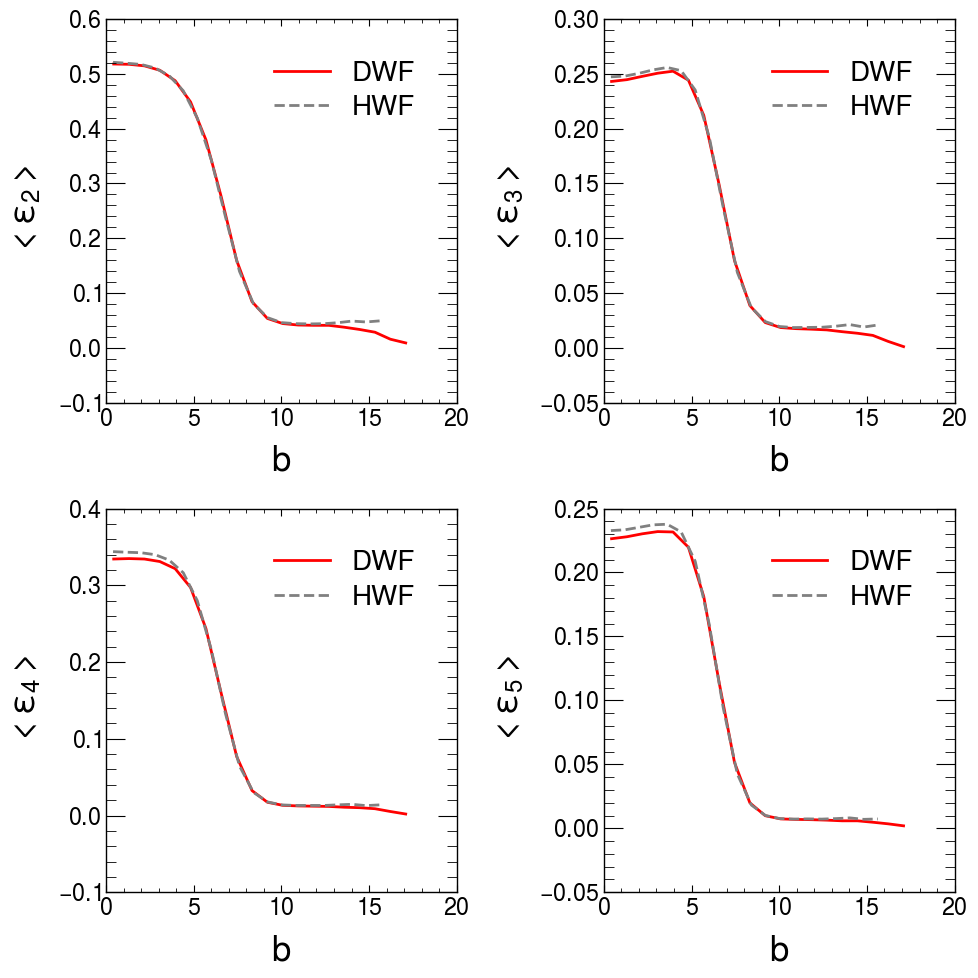

In [6]:
HWF_DWF_sph.plot_multiple_relationships(cols_x=[1, 1, 1, 1], cols_y=[5, 6, 7, 8], bins=20,save_fig=False)

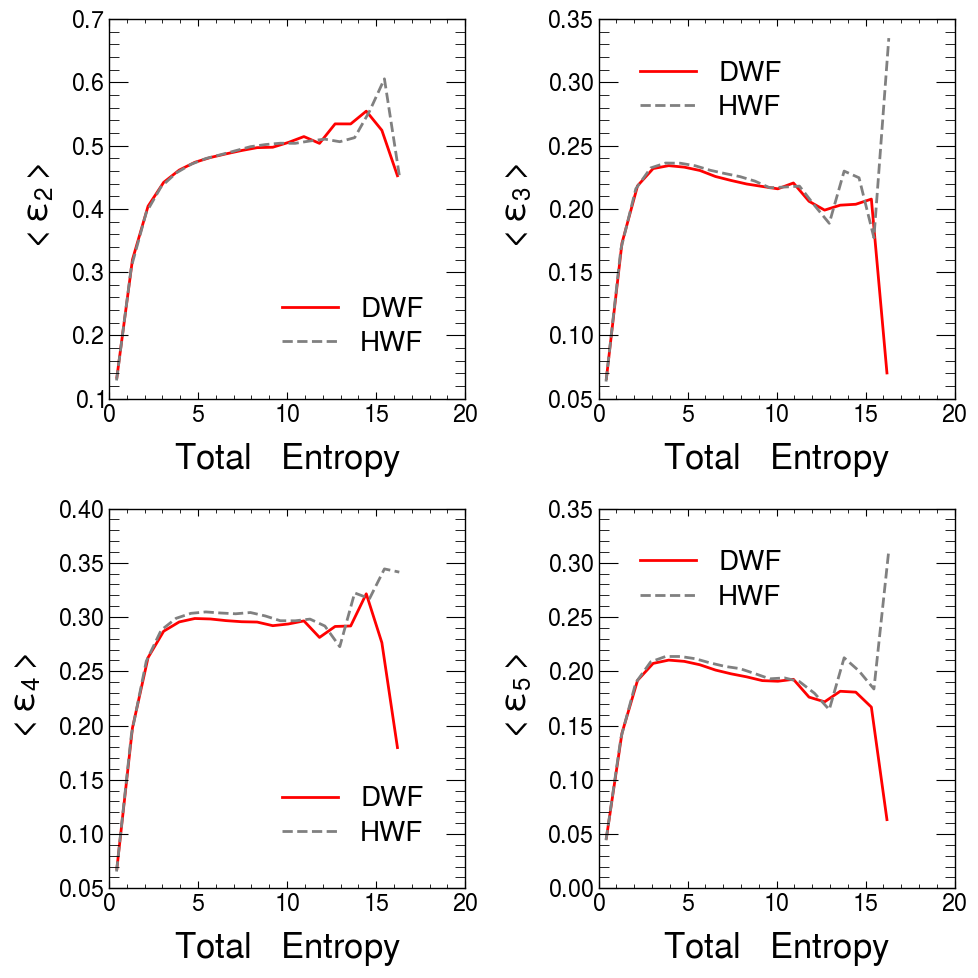

In [71]:
HWF_DWF_sph.plot_multiple_relationships(cols_x=[4, 4, 4, 4], cols_y=[5, 6, 7, 8], bins=20,save_fig=False)

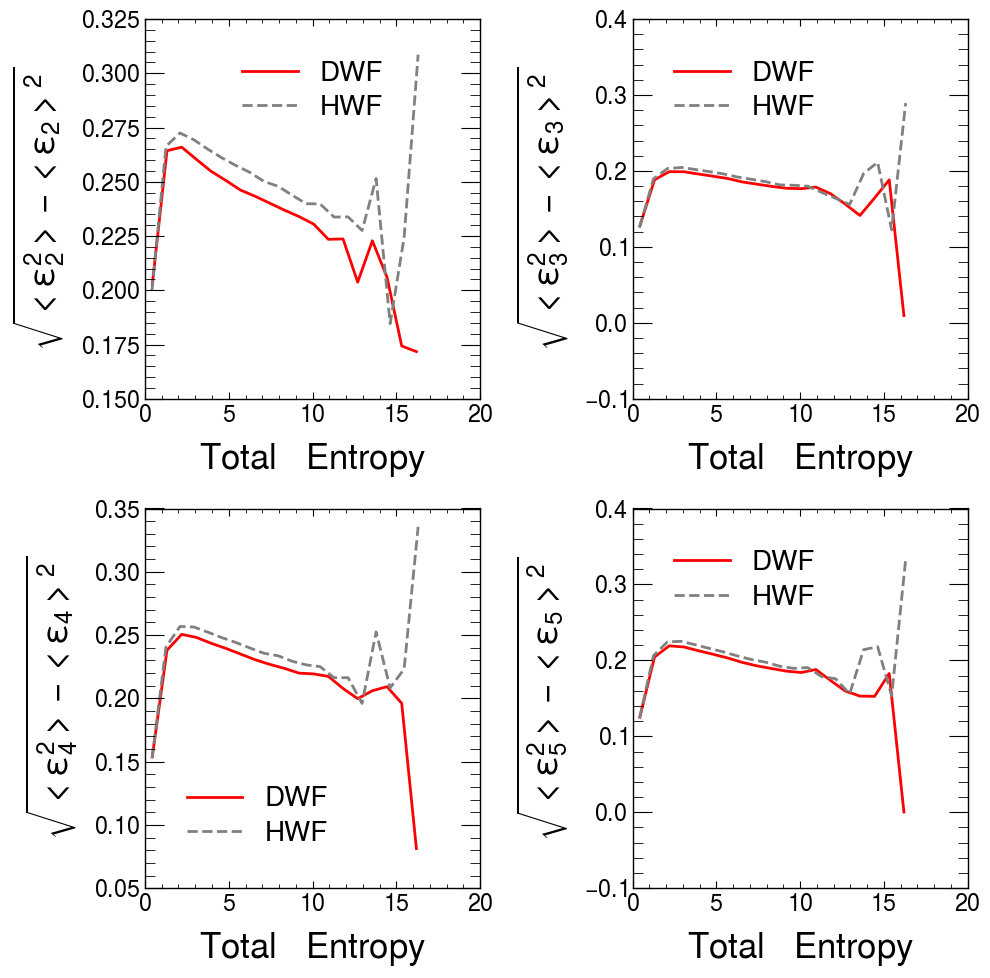

In [72]:
HWF_DWF_sph.plot_multiple_relationships_delta(cols_x=[4, 4, 4, 4], cols_y=[5, 6, 7, 8], bins=20,save_fig=False)

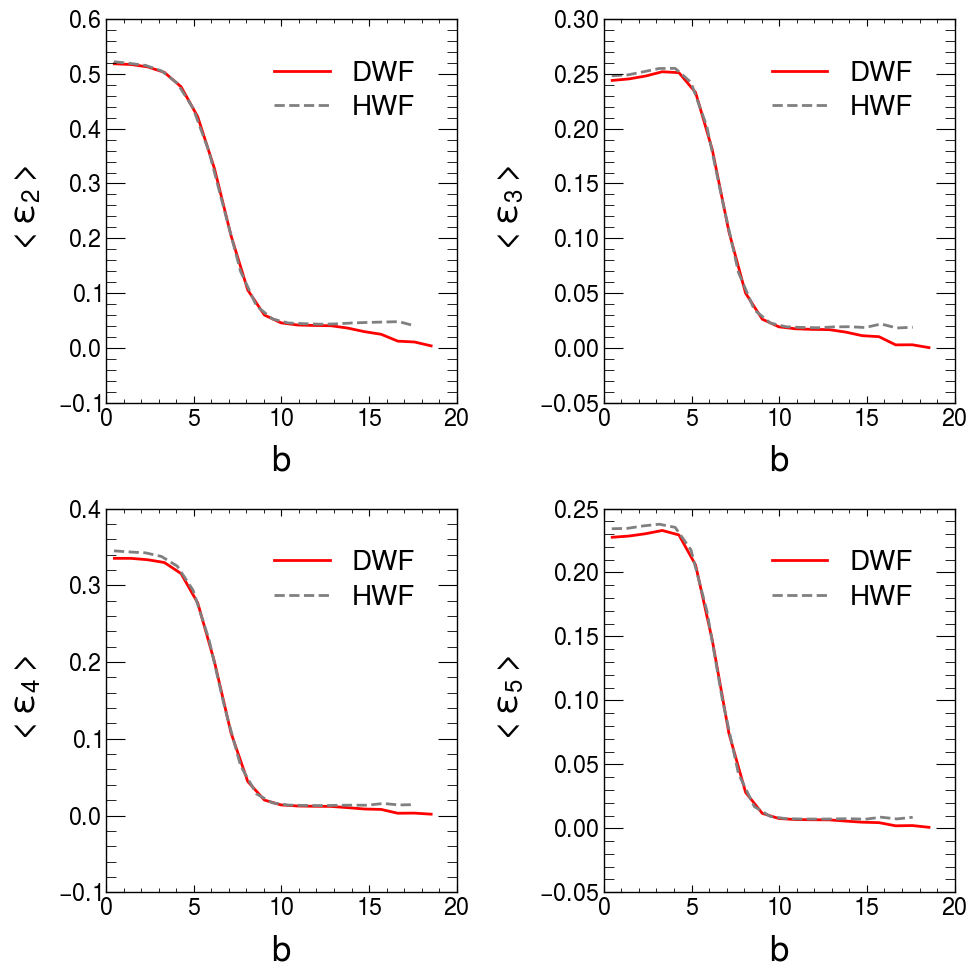

In [8]:
HWF_DWF_def2.plot_multiple_relationships(cols_x=[1, 1, 1, 1], cols_y=[5, 6, 7, 8], bins=20,save_fig=False)

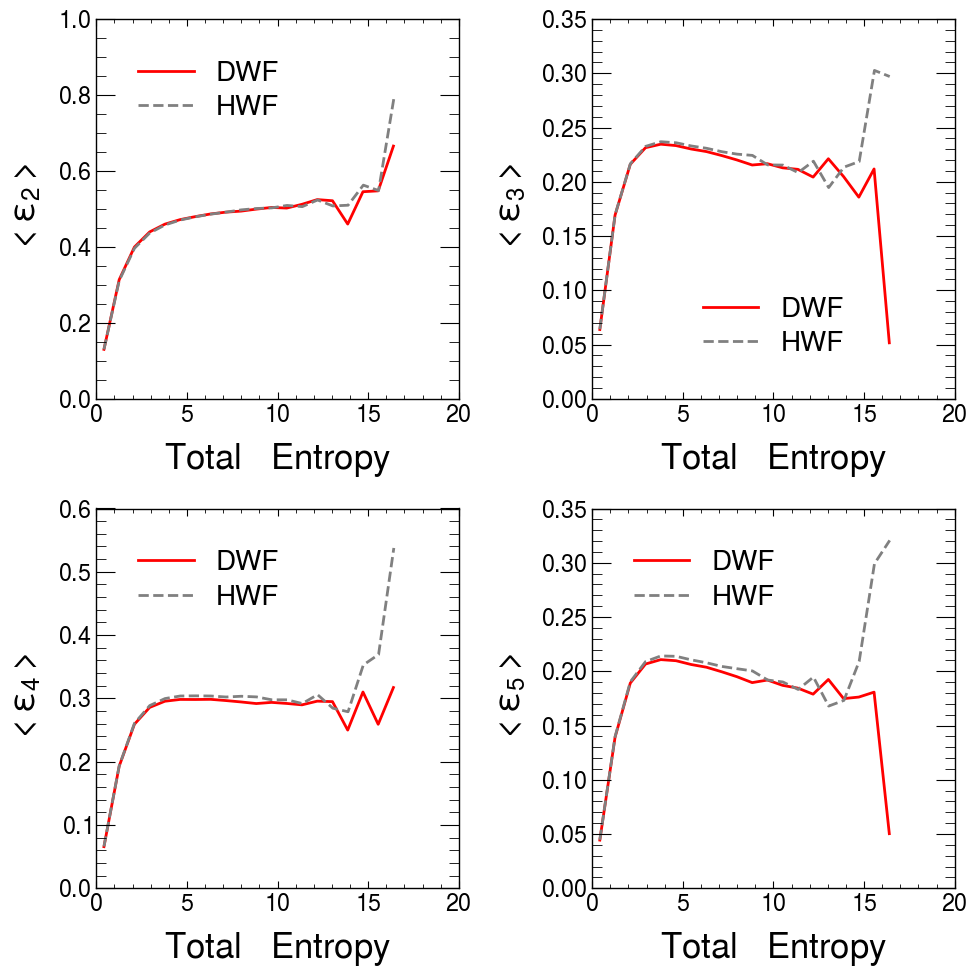

In [73]:
HWF_DWF_def2.plot_multiple_relationships(cols_x=[4, 4, 4, 4], cols_y=[5, 6, 7, 8], bins=20,save_fig=False)

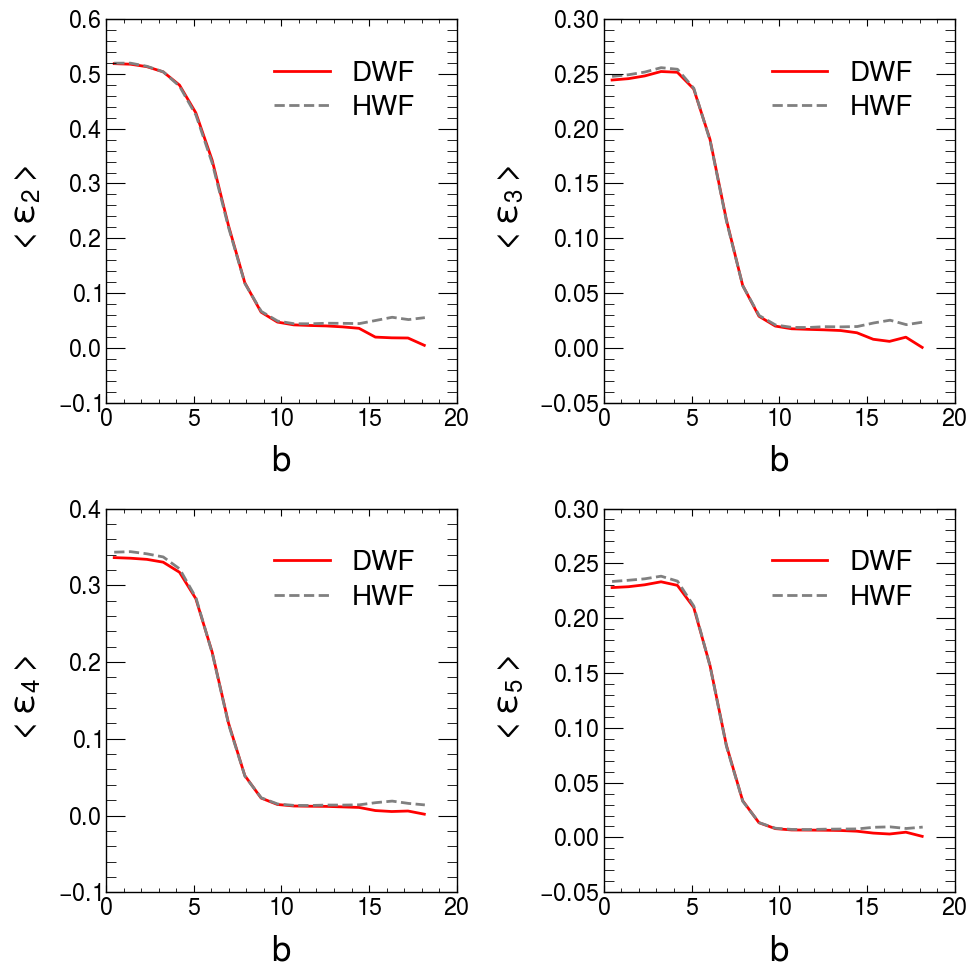

In [9]:
HWF_DWF_def4.plot_multiple_relationships(cols_x=[1, 1, 1, 1], cols_y=[5, 6, 7, 8], bins=20,save_fig=False)

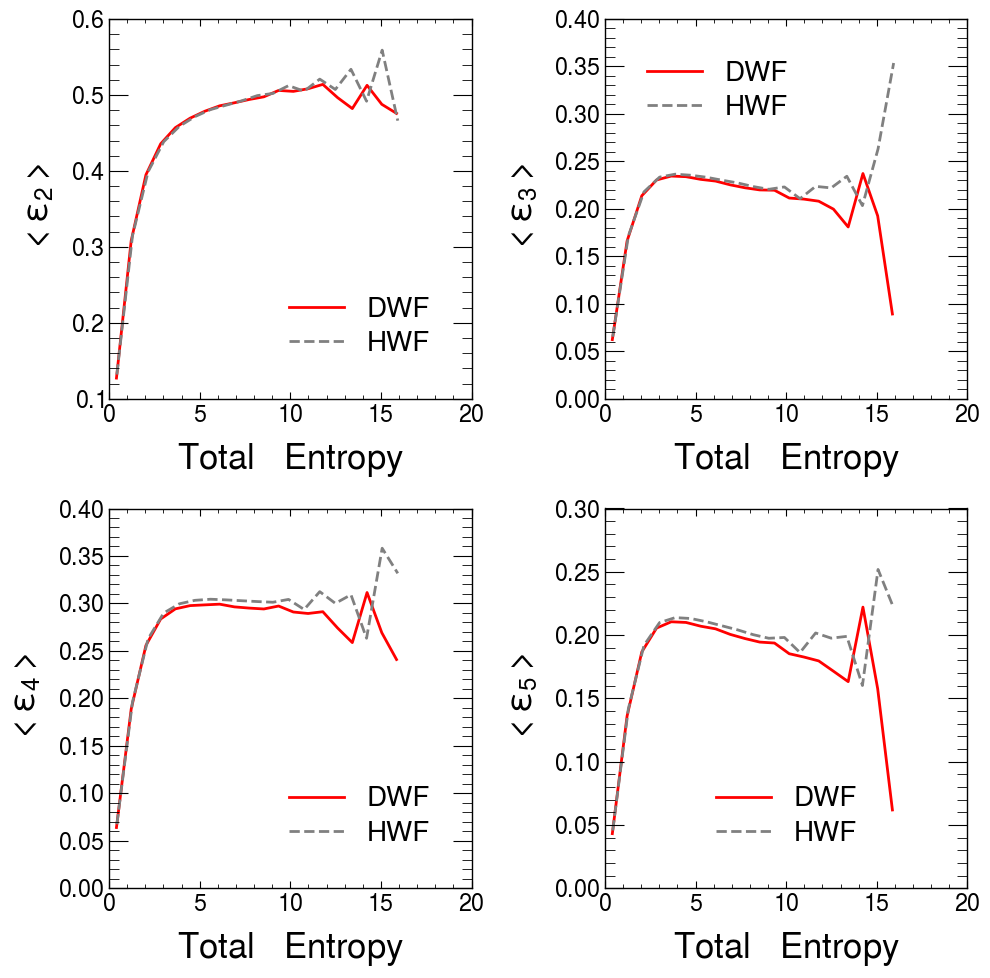

In [74]:
HWF_DWF_def4.plot_multiple_relationships(cols_x=[4, 4, 4, 4], cols_y=[5, 6, 7, 8], bins=20,save_fig=False)

In [16]:
# TRENTo2d_InitialDataVisualizer_without_errorbar 

import matplotlib.ticker as ticker
class TRENTo2d_InitialDataVisualizer:
    def __init__(self, data_DWF, data_HWF, label_DWF="DWF", label_HWF="HWF"):
        """
        初始化类，传入数据
        data_DWF: 第一组数据
        data_HWF: 第二组数据
        label_DWF: 第一组数据的标签名称 (默认"DWF")
        label_HWF: 第二组数据的标签名称 (默认"HWF")
        """
        self.data_DWF = data_DWF
        self.data_HWF = data_HWF
        self.label_DWF = label_DWF
        self.label_HWF = label_HWF
        self.column_labels = {
            1: r"$\rm b$",
            2: r"$\rm N_{part}$",
            3: r"$\rm N_{coll}$",
            4: r"$\rm Total \quad Entropy$",
            5: r"$\rm <\epsilon_2>$",
            6: r"$\rm <\epsilon_3>$",
            7: r"$\rm <\epsilon_4>$",
            8: r"$\rm <\epsilon_5>$"
        }
        self.column_labels_delta = {
            1: r"$\rm b$",
            2: r"$\rm N_{part}$",
            3: r"$\rm N_{coll}$",
            4: r"$\rm Total \quad Entropy$",
            5: r"$\rm \sqrt{<\epsilon_2^2>-<\epsilon_2>^2}$",
            6: r"$\rm \sqrt{<\epsilon_3^2>-<\epsilon_3>^2}$",
            7: r"$\rm \sqrt{<\epsilon_4^2>-<\epsilon_4>^2}$",
            8: r"$\rm \sqrt{<\epsilon_5^2>-<\epsilon_5>^2}$"
        }
        self.column_labels_delta2 = {
            1: r"$\rm b$",
            2: r"$\rm N_{part}$",
            3: r"$\rm N_{coll}$",
            4: r"$\rm Total \quad Entropy$",
            5: r"$\rm <\epsilon_2^2>-<\epsilon_2>^2$",
            6: r"$\rm <\epsilon_3^2>-<\epsilon_3>^2$",
            7: r"$\rm <\epsilon_4^2>-<\epsilon_4>^2$",
            8: r"$\rm <\epsilon_5^2>-<\epsilon_5>^2$"
        }
        self.column_labels_sqr = {
            1: r"$\rm b$",
            2: r"$\rm N_{part}$",
            3: r"$\rm N_{coll}$",
            4: r"$\rm Total \quad Entropy$",
            5: r"$\rm <\epsilon_2^2>$",
            6: r"$\rm <\epsilon_3^2>$",
            7: r"$\rm <\epsilon_4^2>$",
            8: r"$\rm <\epsilon_5^2>$"
        }
        self.column_labels_sqr_sqrt = {
            1: r"$\rm b$",
            2: r"$\rm N_{part}$",
            3: r"$\rm N_{coll}$",
            4: r"$\rm Total \quad Entropy$",
            5: r"$\rm \sqrt{<\epsilon_2^2>}$",
            6: r"$\rm \sqrt{<\epsilon_3^2>}$",
            7: r"$\rm \sqrt{<\epsilon_4^2>}$",
            8: r"$\rm \sqrt{<\epsilon_5^2>}$"
        }

    def calc_column_relationship(self, data, col_x, col_y, bins=100):
        """
        计算两列数据之间的关系，返回区间中心，均值，均方差及误差
        """
        x_data = data[:, col_x]
        y_data = data[:, col_y]

        min_x = np.min(x_data)
        max_x = np.max(x_data)
        step = (max_x - min_x) / bins

        bin_centers = []
        y_means = []
        sqr_y_means = []
        y_errors = []
        sqr_y_errors = []
        
        for i in range(bins):
            lower_bound = min_x + i * step
            upper_bound = min_x + (i + 1) * step
            indices = (x_data >= lower_bound) & (x_data < upper_bound)

            if np.sum(indices) > 0:
                avg_y = np.mean(y_data[indices])
                avg_sqr_y = np.mean(y_data[indices]**2)
                
                std_y = np.std(y_data[indices])
                std_sqr_y = np.std(y_data[indices]**2)
                
                error_y = std_y / np.sqrt(np.sum(indices))
                error_sqr_y = std_sqr_y / np.sqrt(np.sum(indices))
                
                bin_centers.append((lower_bound + upper_bound) / 2)
                y_means.append(avg_y)
                sqr_y_means.append(avg_sqr_y)
                y_errors.append(error_y)
                sqr_y_errors.append(error_sqr_y)
                
        bin_centers = np.array(bin_centers)
        y_means = np.array(y_means)
        sqr_y_means = np.array(sqr_y_means)
        y_errors = np.array(y_errors)
        sqr_y_errors = np.array(sqr_y_errors)
        
        return bin_centers, y_means, sqr_y_means, y_errors, sqr_y_errors

    def plot_column_relationship(self, col_x, col_y, bins=100,loc='best'):
        """
        绘制单张图，比较两列数据之间的关系
        """
        xlabel = self.column_labels.get(col_x, f"Column {col_x}")
        ylabel = self.column_labels.get(col_y, f"Column {col_y}")

        bin_centers_DWF, y_means_DWF, y_means_sqr_DWF, yerr_DWF, yerr_sqr_DWF = self.calc_column_relationship(
            data=self.data_DWF, col_x=col_x, col_y=col_y, bins=bins)
        bin_centers_HWF, y_means_HWF, y_means_sqr_HWF, yerr_HWF, yerr_sqr_HWF = self.calc_column_relationship(
            data=self.data_HWF, col_x=col_x, col_y=col_y, bins=bins)

        plt.plot(bin_centers_DWF, y_means_DWF, linestyle='-', color='red', label=self.label_DWF)
        plt.plot(bin_centers_HWF, y_means_HWF, linestyle='--', color='grey', label=self.label_HWF)
        
        plt.xlabel(xlabel, ha='center', fontsize=25)
        plt.ylabel(ylabel, ha='center', fontsize=25)
        plt.legend(loc=loc,fontsize=20)
    
    def plot_column_relationship_delta(self, col_x, col_y, bins=100,loc='best'):
        """
        绘制单张图，比较两列数据之间的关系
        """
        xlabel = self.column_labels_delta.get(col_x, f"Column {col_x}")
        ylabel = self.column_labels_delta.get(col_y, f"Column {col_y}")

        bin_centers_DWF, y_means_DWF, y_means_sqr_DWF, yerr_DWF, yerr_sqr_DWF = self.calc_column_relationship(
            data=self.data_DWF, col_x=col_x, col_y=col_y, bins=bins)
        bin_centers_HWF, y_means_HWF, y_means_sqr_HWF, yerr_HWF, yerr_sqr_HWF = self.calc_column_relationship(
            data=self.data_HWF, col_x=col_x, col_y=col_y, bins=bins)
        
        delta_y_DWF = y_means_sqr_DWF - y_means_DWF**2
        delta_y_HWF = y_means_sqr_HWF - y_means_HWF**2
        
        plt.plot(bin_centers_DWF, np.sqrt(delta_y_DWF), linestyle='-', color='red', label=self.label_DWF)
        plt.plot(bin_centers_HWF, np.sqrt(delta_y_HWF), linestyle='--', color='grey', label=self.label_HWF)
        
        plt.xlabel(xlabel, ha='center', fontsize=25)
        plt.ylabel(ylabel, ha='center', fontsize=25)
        ax.ticklabel_format(style='scientific', axis='y', scilimits=(-2, 2))
        self._apply_yaxis_format(ax, exponent=-2)  # 调用统一的Y轴格式化函数
        plt.legend(loc=loc,fontsize=20)
    
    def plot_column_relationship_delta2(self, col_x, col_y, bins=100,loc='best'):
        """
        绘制单张图，比较两列数据之间的关系
        """
        xlabel = self.column_labels_delta2.get(col_x, f"Column {col_x}")
        ylabel = self.column_labels_delta2.get(col_y, f"Column {col_y}")

        bin_centers_DWF, y_means_DWF, y_means_sqr_DWF, yerr_DWF, yerr_sqr_DWF = self.calc_column_relationship(
            data=self.data_DWF, col_x=col_x, col_y=col_y, bins=bins)
        bin_centers_HWF, y_means_HWF, y_means_sqr_HWF, yerr_HWF, yerr_sqr_HWF = self.calc_column_relationship(
            data=self.data_HWF, col_x=col_x, col_y=col_y, bins=bins)
        
        delta_y_DWF = y_means_sqr_DWF - y_means_DWF**2
        delta_y_HWF = y_means_sqr_HWF - y_means_HWF**2
        

        plt.plot(bin_centers_DWF, delta_y_DWF, linestyle='-', color='red', label=self.label_DWF)
        plt.plot(bin_centers_HWF, delta_y_HWF, linestyle='--', color='grey', label=self.label_HWF)
        
        plt.xlabel(xlabel, ha='center', fontsize=25)
        plt.ylabel(ylabel, ha='center', fontsize=25)
        plt.legend(loc=loc,fontsize=20)
    
    def plot_column_relationship_sqr(self, col_x, col_y, bins=100,loc='best'):
        """
        绘制单张图，比较两列数据之间的关系
        """
        xlabel = self.column_labels_sqr.get(col_x, f"Column {col_x}")
        ylabel = self.column_labels_sqr.get(col_y, f"Column {col_y}")

        bin_centers_DWF, y_means_DWF, y_means_sqr_DWF, yerr_DWF, yerr_sqr_DWF = self.calc_column_relationship(
            data=self.data_DWF, col_x=col_x, col_y=col_y, bins=bins)
        bin_centers_HWF, y_means_HWF, y_means_sqr_HWF, yerr_HWF, yerr_sqr_HWF = self.calc_column_relationship(
            data=self.data_HWF, col_x=col_x, col_y=col_y, bins=bins)

        plt.plot(bin_centers_DWF, y_means_sqr_DWF, linestyle='-', color='red', label=self.label_DWF)
        plt.plot(bin_centers_HWF, y_means_sqr_HWF, linestyle='--', color='grey', label=self.label_HWF)
        
        plt.xlabel(xlabel, ha='center', fontsize=25)
        plt.ylabel(ylabel, ha='center', fontsize=25)
        plt.legend(loc=loc,fontsize=20)
        
    def plot_multiple_relationships(self, cols_x, cols_y, bins=100, save_fig=False,loc='best'):
        """
        在一个图中绘制多张图表，cols_x 和 cols_y 为要对比的列索引的列表
        """
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 创建2x2的子图

        for i, ax in enumerate(axes.flat):
            col_x = cols_x[i]
            col_y = cols_y[i]

            xlabel = self.column_labels.get(col_x, f"Column {col_x}")
            ylabel = self.column_labels.get(col_y, f"Column {col_y}")

            bin_centers_DWF, y_means_DWF, y_means_sqr_DWF, yerr_DWF, yerr_sqr_DWF  = self.calc_column_relationship(
                data=self.data_DWF, col_x=col_x, col_y=col_y, bins=bins)
            bin_centers_HWF, y_means_HWF, y_means_sqr_HWF, yerr_HWF, yerr_sqr_HWF = self.calc_column_relationship(
                data=self.data_HWF, col_x=col_x, col_y=col_y, bins=bins)

            ax.plot(bin_centers_DWF, y_means_DWF, linestyle='-', color='red', label=self.label_DWF)
            ax.plot(bin_centers_HWF, y_means_HWF, linestyle='--', color='grey', label=self.label_HWF)
            
            ax.set_xlabel(xlabel, ha='center', fontsize=25)
            ax.set_ylabel(ylabel, ha='center', fontsize=25)
            ax.legend(loc=loc,fontsize=20)
            
        plt.tight_layout()
        
        if save_fig:
            # 生成保存文件名
            save_ylabel = ylabel.replace("$", "").replace("\\", "").replace("5", "n")
            save_xlabel = xlabel.replace("$", "").replace("\\", "")
            save_path = f"/home/mengzhu/mywork/d_Au_work/fig/{save_ylabel}_vs_{save_xlabel}.pdf"
            os.makedirs("/home/mengzhu/mywork/d_Au_work/fig", exist_ok=True)  # 确保目录存在
            plt.savefig(save_path, bbox_inches="tight")
            print(f"Figure saved to {save_path}") 
#         plt.show()
        
    def plot_multiple_relationships_delta(self, cols_x, cols_y, bins=100, save_fig=False,loc='best'):
        """
        在一个图中绘制多张图表，cols_x 和 cols_y 为要对比的列索引的列表
        """
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 创建2x2的子图

        for i, ax in enumerate(axes.flat):
            col_x = cols_x[i]
            col_y = cols_y[i]

            xlabel = self.column_labels_delta.get(col_x, f"Column {col_x}")
            ylabel = self.column_labels_delta.get(col_y, f"Column {col_y}")

            bin_centers_DWF, y_means_DWF, y_means_sqr_DWF, yerr_DWF, yerr_sqr_DWF = self.calc_column_relationship(
                data=self.data_DWF, col_x=col_x, col_y=col_y, bins=bins)
            bin_centers_HWF, y_means_HWF, y_means_sqr_HWF, yerr_HWF, yerr_sqr_HWF = self.calc_column_relationship(
                data=self.data_HWF, col_x=col_x, col_y=col_y, bins=bins)
            
            delta_y_DWF = y_means_sqr_DWF - y_means_DWF**2
            delta_y_HWF = y_means_sqr_HWF - y_means_HWF**2
    
            ax.plot(bin_centers_DWF, np.sqrt(delta_y_DWF), linestyle='-', color='red', label=self.label_DWF)
            ax.plot(bin_centers_HWF, np.sqrt(delta_y_HWF), linestyle='--', color='grey', label=self.label_HWF)
            
            ax.set_xlabel(xlabel, ha='center', fontsize=25)
            ax.set_ylabel(ylabel, ha='center', fontsize=25)
            ax.legend(loc=loc,fontsize=20)

        plt.tight_layout()
        
        if save_fig:
            # 生成保存文件名
            save_ylabel = ylabel.replace("$", "").replace("\\", "").replace("5", "n")
            save_xlabel = xlabel.replace("$", "").replace("\\", "")
            save_path = f"/home/mengzhu/mywork/d_Au_work/fig/{save_ylabel}_vs_{save_xlabel}.pdf"
            os.makedirs("/home/mengzhu/mywork/d_Au_work/fig", exist_ok=True)  # 确保目录存在
            plt.savefig(save_path, bbox_inches="tight")
            print(f"Figure saved to {save_path}")       
#         plt.show()
    
    def plot_multiple_relationships_delta2(self, cols_x, cols_y, bins=100, save_fig=False,loc='best'):
        """
        在一个图中绘制多张图表，cols_x 和 cols_y 为要对比的列索引的列表
        """
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 创建2x2的子图

        for i, ax in enumerate(axes.flat):
            col_x = cols_x[i]
            col_y = cols_y[i]

            xlabel = self.column_labels_delta2.get(col_x, f"Column {col_x}")
            ylabel = self.column_labels_delta2.get(col_y, f"Column {col_y}")

            bin_centers_DWF, y_means_DWF, y_means_sqr_DWF, yerr_DWF, yerr_sqr_DWF = self.calc_column_relationship(
                data=self.data_DWF, col_x=col_x, col_y=col_y, bins=bins)
            bin_centers_HWF, y_means_HWF, y_means_sqr_HWF, yerr_HWF, yerr_sqr_HWF = self.calc_column_relationship(
                data=self.data_HWF, col_x=col_x, col_y=col_y, bins=bins)
            
            delta_y_DWF = y_means_sqr_DWF - y_means_DWF**2
            delta_y_HWF = y_means_sqr_HWF - y_means_HWF**2
    
            ax.plot(bin_centers_DWF, delta_y_DWF, linestyle='-', color='red', label=self.label_DWF)
            ax.plot(bin_centers_HWF, delta_y_HWF, linestyle='--', color='grey', label=self.label_HWF)
            
            ax.set_xlabel(xlabel, ha='center', fontsize=25)
            ax.set_ylabel(ylabel, ha='center', fontsize=25)
            # 使用自定义的 FuncFormatter 设置纵坐标的刻度格式
            def format_func(value, tick_number):
                return f'{value * 100:.0f}'  # 将刻度乘以100以转换为10^-2格式

            ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_func))

            # 添加额外的文本来显示乘法因子
            ax.annotate(r'$\times10^{-2}$', xy=(0.02, 1.02), xycoords='axes fraction', fontsize=18)
            ax.legend(loc=loc,fontsize=20)

        plt.tight_layout()
        
        if save_fig:
            # 生成保存文件名
            save_ylabel = ylabel.replace("$", "").replace("\\", "").replace("5", "n")
            save_xlabel = xlabel.replace("$", "").replace("\\", "")
            save_path = f"/home/mengzhu/mywork/d_Au_work/fig/{save_ylabel}_vs_{save_xlabel}.pdf"
            os.makedirs("/home/mengzhu/mywork/d_Au_work/fig", exist_ok=True)  # 确保目录存在
            plt.savefig(save_path, bbox_inches="tight")
            print(f"Figure saved to {save_path}")    
#         plt.show()
    
    def plot_multiple_relationships_sqr(self, cols_x, cols_y, bins=100, save_fig=False,loc='best'):
        """
        在一个图中绘制多张图表，cols_x 和 cols_y 为要对比的列索引的列表
        """
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 创建2x2的子图

        for i, ax in enumerate(axes.flat):
            col_x = cols_x[i]
            col_y = cols_y[i]

            xlabel = self.column_labels_sqr.get(col_x, f"Column {col_x}")
            ylabel = self.column_labels_sqr.get(col_y, f"Column {col_y}")

            bin_centers_DWF, y_means_DWF, y_means_sqr_DWF, yerr_DWF, yerr_sqr_DWF = self.calc_column_relationship(
                data=self.data_DWF, col_x=col_x, col_y=col_y, bins=bins)
            bin_centers_HWF, y_means_HWF, y_means_sqr_HWF, yerr_HWF, yerr_sqr_HWF = self.calc_column_relationship(
                data=self.data_HWF, col_x=col_x, col_y=col_y, bins=bins)
    
            ax.plot(bin_centers_DWF, y_means_sqr_DWF, linestyle='-', color='red', label=self.label_DWF)
            ax.plot(bin_centers_HWF, y_means_sqr_HWF, linestyle='--', color='grey', label=self.label_HWF)
            
            ax.set_xlabel(xlabel, ha='center', fontsize=25)
            ax.set_ylabel(ylabel, ha='center', fontsize=25)
            ax.legend(loc=loc,fontsize=20)

        plt.tight_layout()
        
        if save_fig:
            # 生成保存文件名
            save_ylabel = ylabel.replace("$", "").replace("\\", "").replace("5", "n")
            save_xlabel = xlabel.replace("$", "").replace("\\", "")
            save_path = f"/home/mengzhu/mywork/d_Au_work/fig/{save_ylabel}_vs_{save_xlabel}.pdf"
            os.makedirs("/home/mengzhu/mywork/d_Au_work/fig", exist_ok=True)  # 确保目录存在
            plt.savefig(save_path, bbox_inches="tight")
            print(f"Figure saved to {save_path}")    
#         plt.show()

    def plot_multiple_relationships_sqr_sqrt(self, cols_x, cols_y, bins=100, save_fig=False,loc='best'):
        """
        在一个图中绘制多张图表，cols_x 和 cols_y 为要对比的列索引的列表
        """
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 创建2x2的子图

        for i, ax in enumerate(axes.flat):
            col_x = cols_x[i]
            col_y = cols_y[i]

            xlabel = self.column_labels_sqr_sqrt.get(col_x, f"Column {col_x}")
            ylabel = self.column_labels_sqr_sqrt.get(col_y, f"Column {col_y}")

            bin_centers_DWF, y_means_DWF, y_means_sqr_DWF, yerr_DWF, yerr_sqr_DWF = self.calc_column_relationship(
                data=self.data_DWF, col_x=col_x, col_y=col_y, bins=bins)
            bin_centers_HWF, y_means_HWF, y_means_sqr_HWF, yerr_HWF, yerr_sqr_HWF = self.calc_column_relationship(
                data=self.data_HWF, col_x=col_x, col_y=col_y, bins=bins)
    
            ax.plot(bin_centers_DWF, np.sqrt(y_means_sqr_DWF), linestyle='-', color='red', label=self.label_DWF)
            ax.plot(bin_centers_HWF, np.sqrt(y_means_sqr_HWF), linestyle='--', color='grey', label=self.label_HWF)
            
            ax.set_xlabel(xlabel, ha='center', fontsize=25)
            ax.set_ylabel(ylabel, ha='center', fontsize=25)
            ax.legend(loc=loc,fontsize=20)

        plt.tight_layout()
        
        if save_fig:
            # 生成保存文件名
            save_ylabel = ylabel.replace("$", "").replace("\\", "").replace("5", "n")
            save_xlabel = xlabel.replace("$", "").replace("\\", "")
            save_path = f"/home/mengzhu/mywork/d_Au_work/fig/{save_ylabel}_vs_{save_xlabel}.pdf"
            os.makedirs("/home/mengzhu/mywork/d_Au_work/fig", exist_ok=True)  # 确保目录存在
            plt.savefig(save_path, bbox_inches="tight")
            print(f"Figure saved to {save_path}")    
#         plt.show()


In [33]:
# 实例化时指定自定义标签
visualizer = TRENTo2d_InitialDataVisualizer(
    data_DWF=trento2d_DWF_sph,
    data_HWF=trento2d_DWF_def2,
    label_DWF=r'$\beta_2=0$',  # 自定义第一组数据标签
    label_HWF=r'$\beta_2=-0.131$'    # 自定义第二组数据标签
)


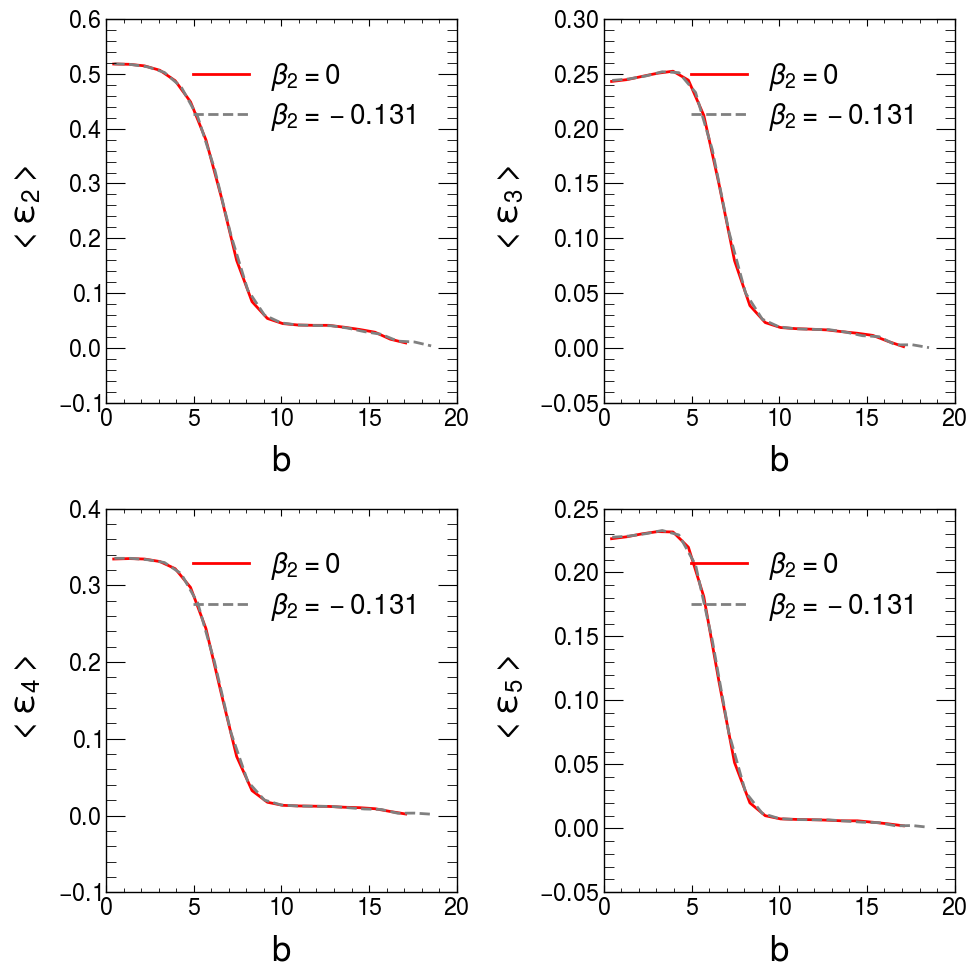

In [34]:
# 使用绘图方法时，会自动使用自定义的标签
visualizer.plot_multiple_relationships(cols_x=[1, 1, 1, 1], cols_y=[5, 6, 7, 8], bins=20,loc='upper right',save_fig=False)

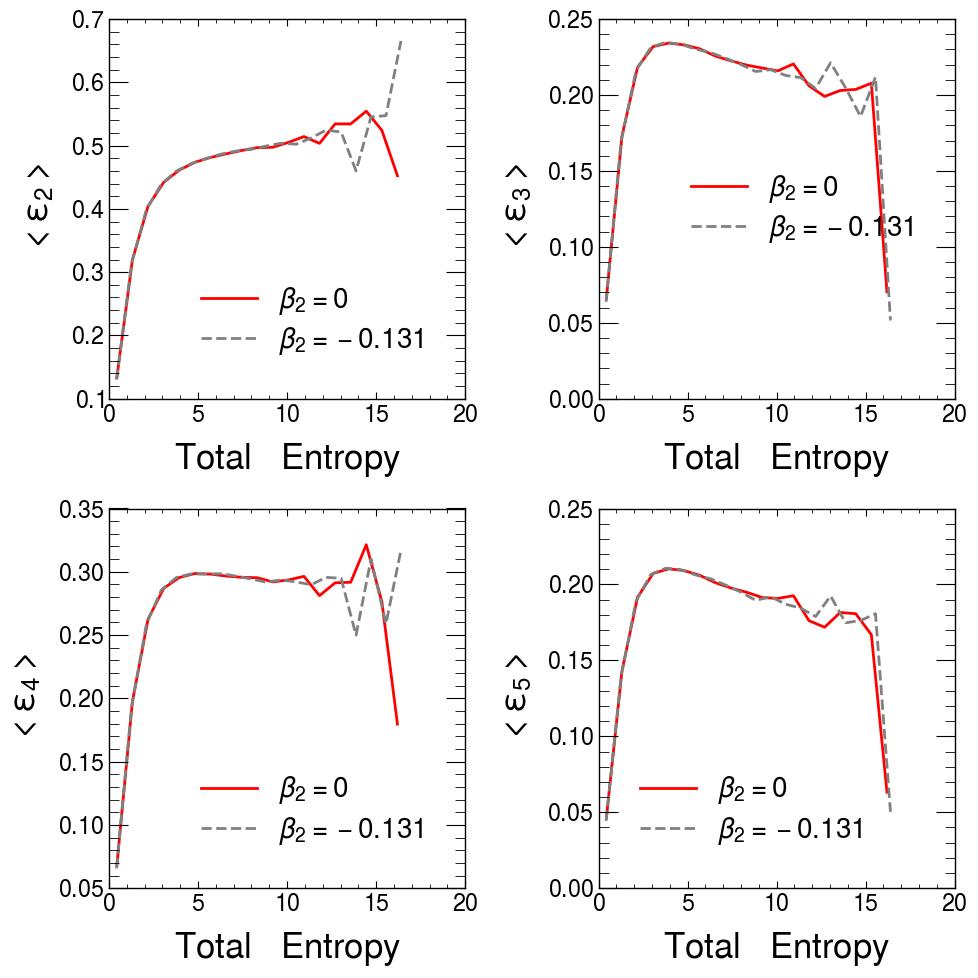

In [78]:
visualizer.plot_multiple_relationships(cols_x=[4, 4, 4, 4], cols_y=[5, 6, 7, 8], bins=20,save_fig=False)

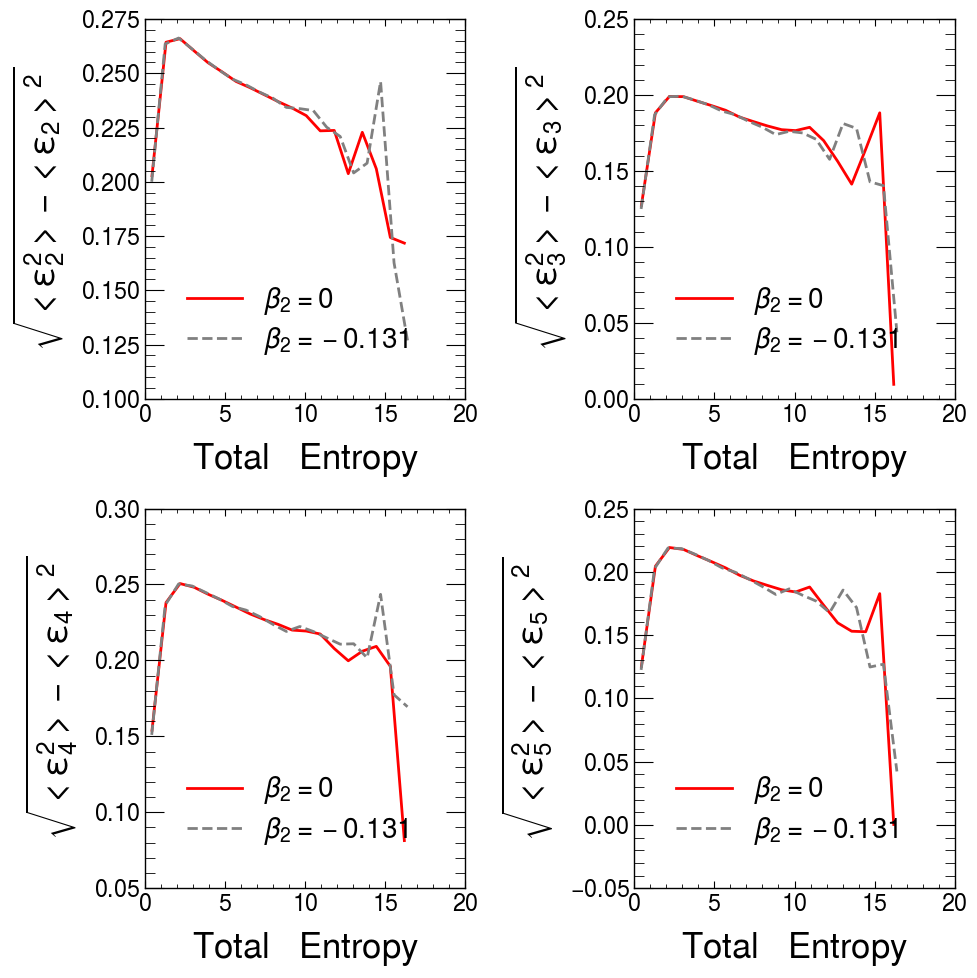

In [35]:
visualizer.plot_multiple_relationships_delta(cols_x=[4, 4, 4, 4], cols_y=[5, 6, 7, 8], bins=20,loc='lower left',save_fig=False)

In [42]:
visualizer2 = TRENTo2d_InitialDataVisualizer(
    data_DWF=trento2d_DWF_sph,
    data_HWF=trento2d_DWF_def4,
    label_DWF=r'$\beta_2=0$',  # 自定义第一组数据标签
    label_HWF=r'$\beta_2, \beta_4$'    # 自定义第二组数据标签
)

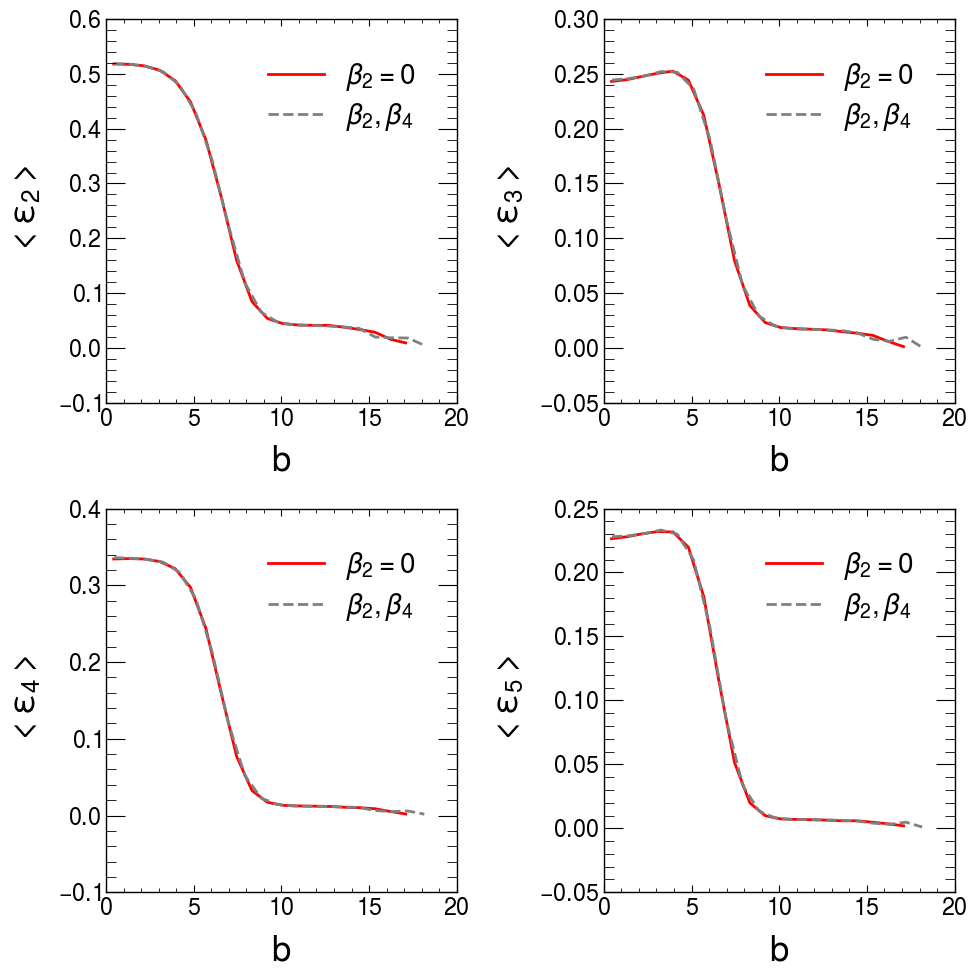

In [43]:
# 使用绘图方法时，会自动使用自定义的标签
visualizer2.plot_multiple_relationships(cols_x=[1, 1, 1, 1], cols_y=[5, 6, 7, 8], bins=20,save_fig=False)

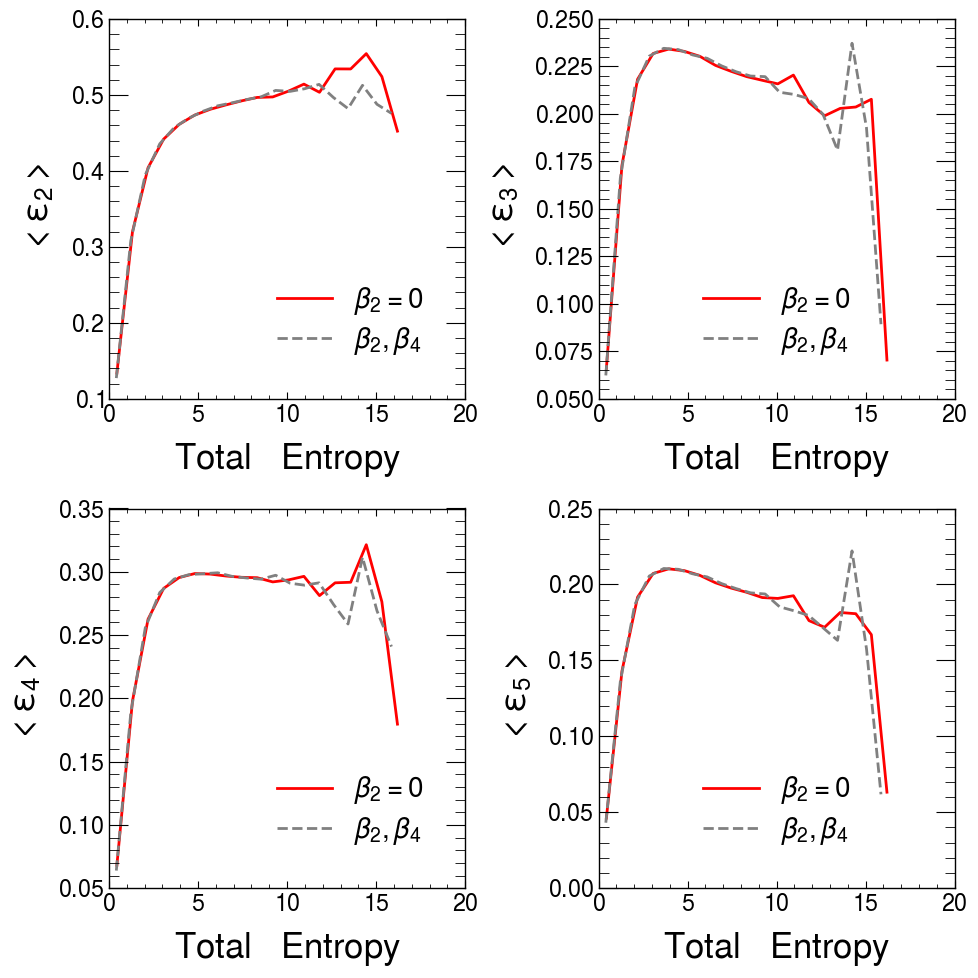

In [76]:
# 使用绘图方法时，会自动使用自定义的标签
visualizer2.plot_multiple_relationships(cols_x=[4, 4, 4, 4], cols_y=[5, 6, 7, 8], bins=20,save_fig=False)

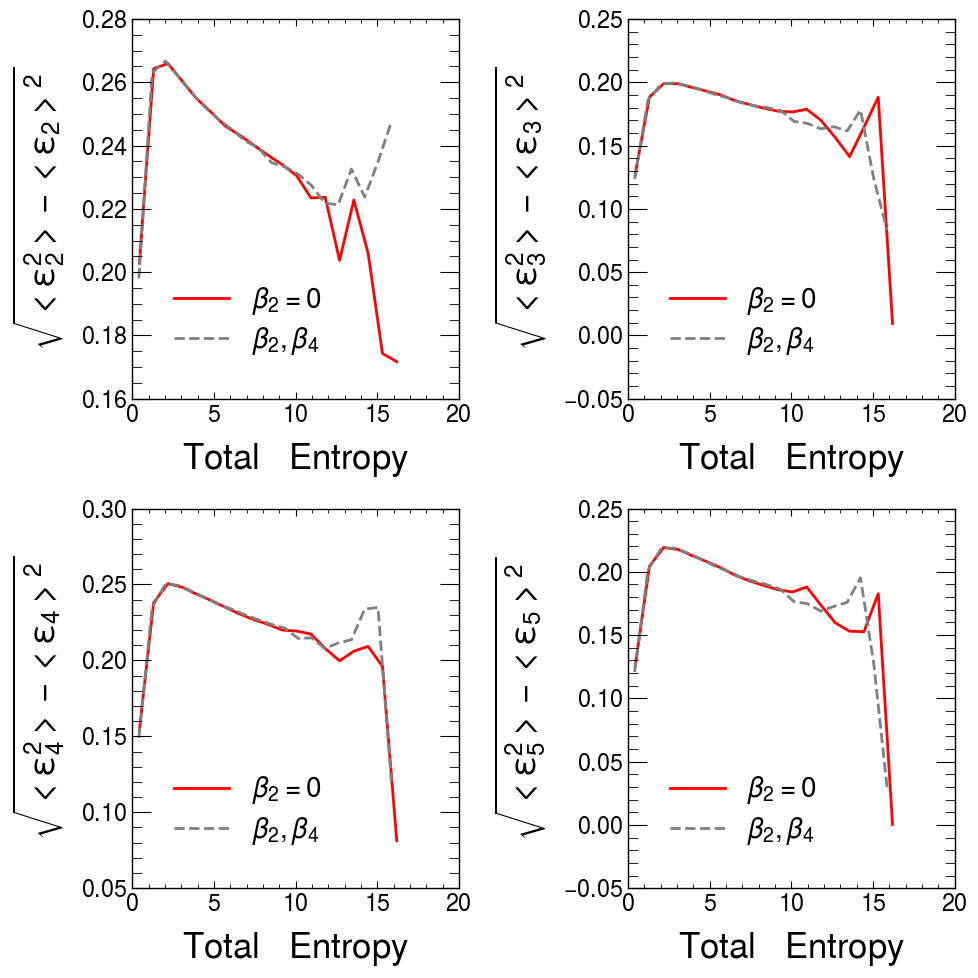

In [44]:
visualizer2.plot_multiple_relationships_delta(cols_x=[4, 4, 4, 4], cols_y=[5, 6, 7, 8], bins=20,save_fig=False)

In [51]:
visualizer3 = TRENTo2d_InitialDataVisualizer(
    data_DWF=trento2d_DWF_def2,
    data_HWF=trento2d_DWF_def4,
    label_DWF=r'$\beta_2$',  # 自定义第一组数据标签
    label_HWF=r'$\beta_2,\beta_4$'    # 自定义第二组数据标签
)

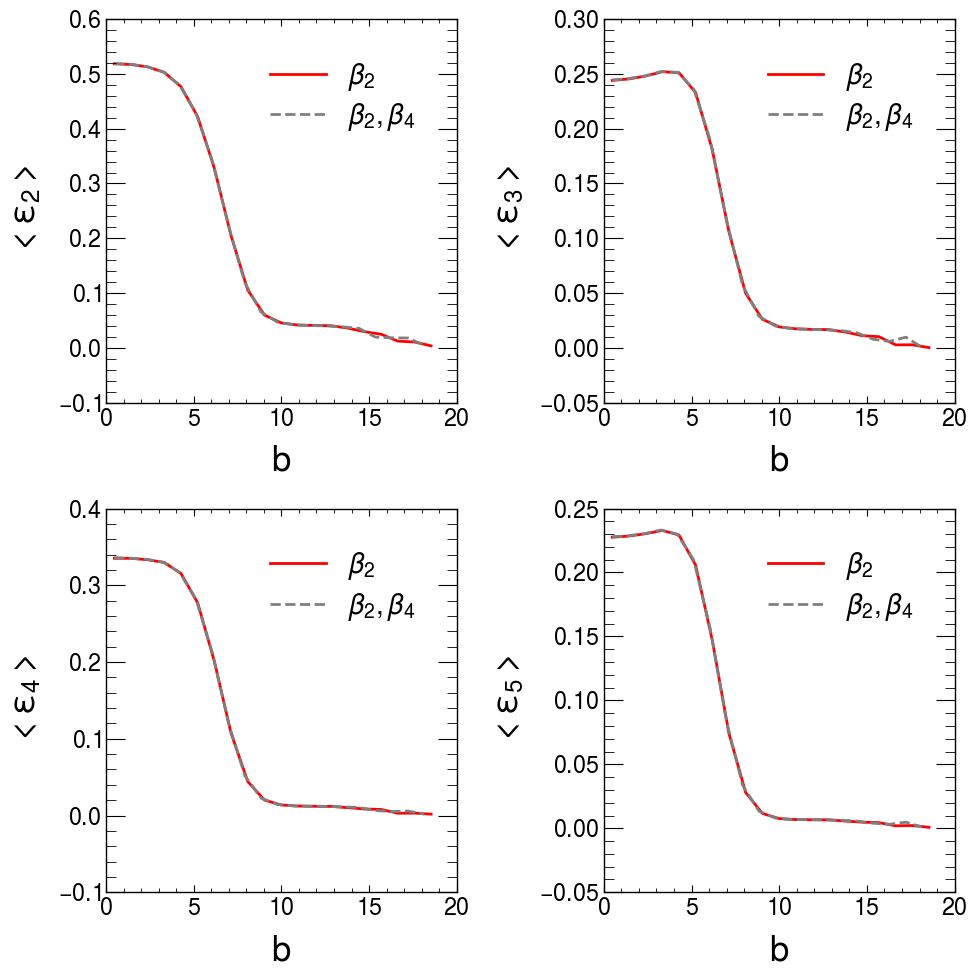

In [52]:
# 使用绘图方法时，会自动使用自定义的标签
visualizer3.plot_multiple_relationships(cols_x=[1, 1, 1, 1], cols_y=[5, 6, 7, 8], bins=20,save_fig=False)

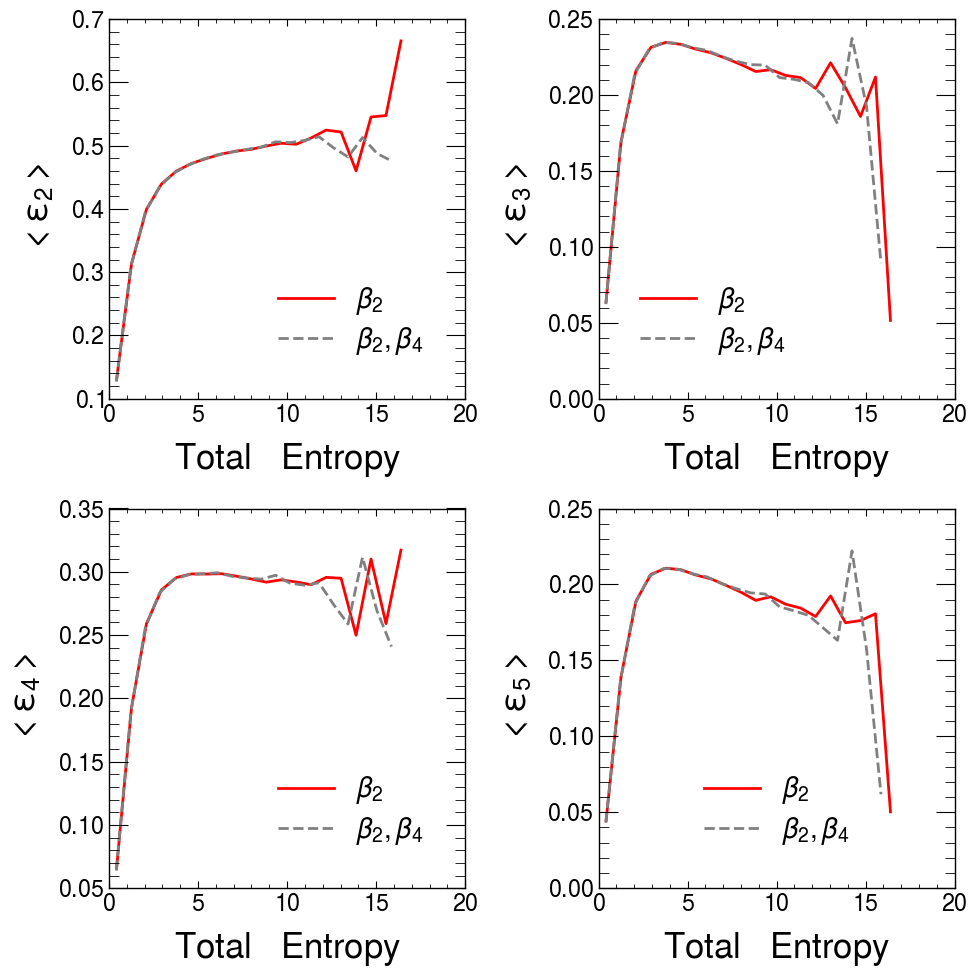

In [77]:
# 使用绘图方法时，会自动使用自定义的标签
visualizer3.plot_multiple_relationships(cols_x=[4, 4, 4, 4], cols_y=[5, 6, 7, 8], bins=20,save_fig=False)

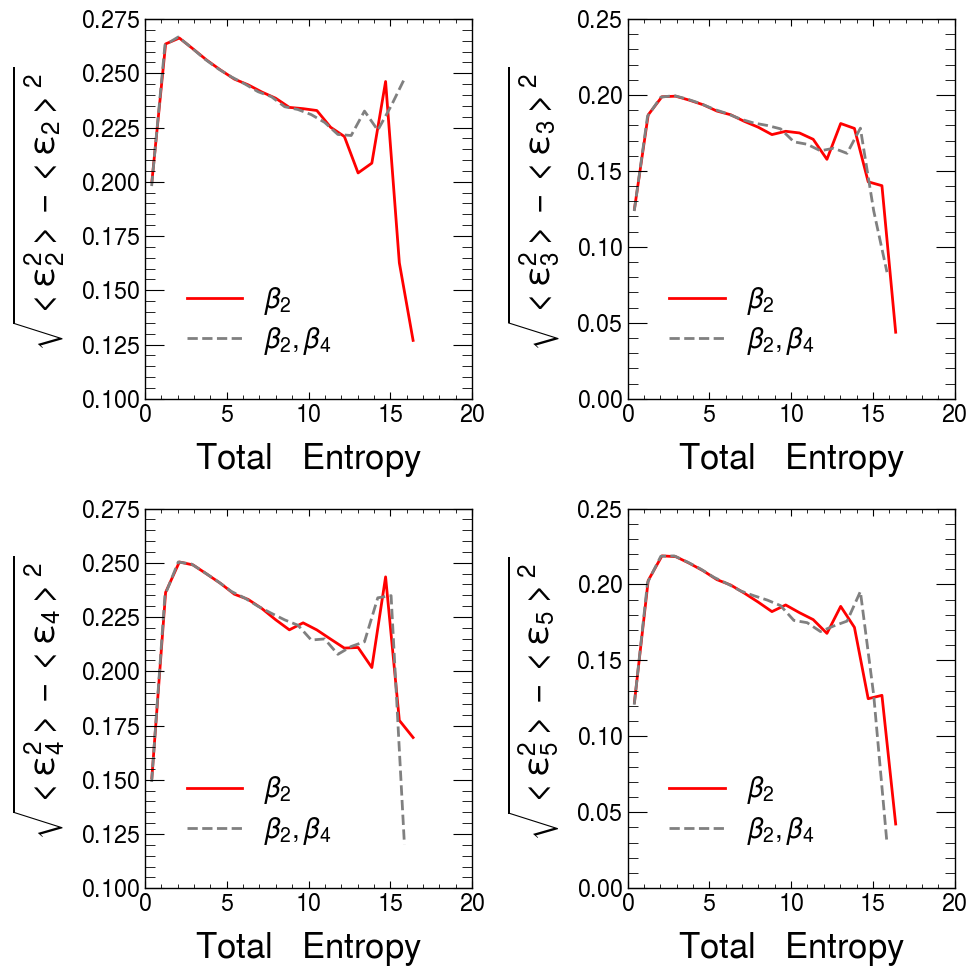

In [53]:
visualizer3.plot_multiple_relationships_delta(cols_x=[4, 4, 4, 4], cols_y=[5, 6, 7, 8], bins=20,save_fig=False)